In [3]:
import sys 
sys.path.append("../Classes")
from HomGraph import *
from SFGraph import *
from sighelp import *

from AttractorGraph import * 
from matplotlib.pyplot import cm
from matplotlib.mlab import frange
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import sparse
import scipy as scp
from scipy.sparse import csgraph

import networkx as nx 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from functools import reduce

from matplotlib import rcParams
sns.set(context='paper',font_scale = 7,
        rc = {'figure.figsize' : (20,10), 'legend.frameon':True, 
              'legend.loc': 'upper right', "xtick.major.size": 10,"ytick.major.size": 10,
             "xtick.minor.size": 6,"ytick.minor.size": 6, 
              "xtick.major.width": 3, "ytick.major.width": 3,
             "xtick.minor.width": 1, "ytick.minor.width": 1, 'lines.linewidth':7})

# sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("coolwarm")
plt.rc("axes.spines", top=False, right=False)




## Functions to take the hamming dsitance with blocked hub nodes or oscillating hub nodes

In [7]:
def oscil_perturb_and_hamming(graph, d, time, period, hub): 
    '''
        Perturb fraction 'd' of the nodes in graph
        Oscillate hub=hub at period=period for time=time
        Return hamming distance bewteen perturb trajectory and original
    '''
    
    start_config = np.copy(graph.get_config())
    tbl1 = graph.oscillate_update(force_start_on=True, 
                                  node_index=hub, period=period, 
                                  time = 2000)

    graph.set_config(np.copy(start_config))
    graph.perturb_network(p=d)
    tbl2 = graph.oscillate_update(force_start_on=True, 
                                  node_index=hub, period=period, 
                                  time=time)
    return Graph.hamming_distance_table(tbl1, tbl2)

def block_perturb_and_hamming(graph, d, time, hub): 
    '''
        Perturb fraction 'd' of the nodes in graph
        Block hub=hub at period=period for time=time
        Return hamming distance bewteen perturb trajectory and original
        
        Note** we do not allow perturbing the hub node..
    '''
    
    start_config = np.copy(graph.get_config())
    start_state = start_config[hub, 0]
    tbl1 = graph.update_return_table_blocked(state=start_state, 
                                             node=hub, time = 2000)

    graph.set_config(np.copy(start_config))
    graph.perturb_network(p=d)
    tbl2 = graph.update_return_table_blocked(state=start_state, 
                                             node=hub, time = 2000)
    return Graph.hamming_distance_table(tbl1, tbl2)

def calculate_avg_oscil_for_graph(graph, d, time, period, hub, ic): 
    '''
        For some number of initial conditions
        Calculate h(t) 
    '''
    my_ar = []
    for j in range(ic): 
        graph.random_config()
        my_ar.append(oscil_perturb_and_hamming(graph, d, time, 
                                               period, hub))
    return np.average(my_ar, axis=0)

def calculate_avg_block_for_graph(graph, d, time, hub, ic): 
    '''
        For some number of initial conditions
        Calculate h(t) 
    '''
    my_ar = []
    for j in range(ic): 
        graph.random_config()
        my_ar.append(block_perturb_and_hamming(graph, d, time, hub))
    return np.average(my_ar, axis=0)
    
def avg_oscil_gamma_hamming(n, gamma, d, time, period, ic, trials): 
    '''
        For a given gamma, generate trials networks, 
        do ic initial conditions of each 
    '''
    my_ar = []
    for j in range(trials): 
        my_graph = SFGraph(n, gamma)
        hub = my_graph.find_hub()
        my_ar.append(calculate_avg_oscil_for_graph(my_graph, d=d, time=time, 
                                      period=period, hub=hub, ic=ic))
    return np.average(my_ar, axis=0)


def avg_block_gamma_hamming(n, gamma, d, time, ic, trials): 
    '''
        For a given gamma, generate trials networks, 
        do ic initial conditions of each 
    '''
    my_ar = []
    for j in range(trials): 
        my_graph = SFGraph(n, gamma)
        hub = my_graph.find_hub()
        my_ar.append(calculate_avg_block_for_graph(my_graph, d=d, time=time,
                                                   hub=hub, ic=ic))
    return np.average(my_ar, axis=0)
        
        

In [9]:

# Try to write this out to a file


def plot_avg_network_hamming_distances_sf_spectrum(n, ic, d, t, trials, size = 22, period=None,):
    """
        For a spectrum of connectivity parameters plot the avearge hamming distance & control parameter graphs
        Do this for MULTIPLE realizations for each conncetivity parameter. Find hamming distnace for this network over several intiial conditions 
    """
    plt.figure(figsize=(33,20))
    f = open("SFHammingOscilResultPer=%s.txt" % period, "w")
    f.write("Scale Free Network Blocked hub nodes, n = %d, d = %.2f, t = %d, ic = %d, r = %d, period = %s\n" %(n, d, t, ic, trials, period))
    color = iter(cm.rainbow(np.linspace(0,1,30)))
    arlist = []
    myRange = np.linspace(1.2,3.5,30)
    plt.subplot(121)
    for gam in myRange:
        if period is None: 
            arlist.append(avg_block_gamma_hamming(n=n, gamma=gam, d=d, time=t, ic=ic, trials=trials))
        else: 
            arlist.append(avg_oscil_gamma_hamming(n=n, gamma=gam, d=d, time=t, period=period,
                                                  ic=ic, trials=trials))            
    for i,ar in enumerate(arlist):
        c = next(color)
        f.write("\t".join([str(j) for j in ar]) + "\n")
        plt.plot(ar, color=c, label=r"$\gamma$ = %.2f" % myRange[i])
        
    # Also tack on the plot for the average of each
    legend = plt.legend(frameon=True, framealpha=1)#, bbox_to_anchor=(1.1, 1.05))
    plt.ylabel("h(t)", size = 22)
    plt.xlabel("Time (t)", size = 22)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    meanAr = []
    for ar in arlist:
        # Only taking the mean after t/2
        meanAr.append(np.mean(ar[t//2:]))
    plt.subplot(122)
    plt.plot(myRange, meanAr)
    plt.xlabel(r'Control Parameter $\gamma$', size = 22)
    plt.ylabel('Order Parameter <h(t)>', size = 22)
    plt.show()
    f.close()

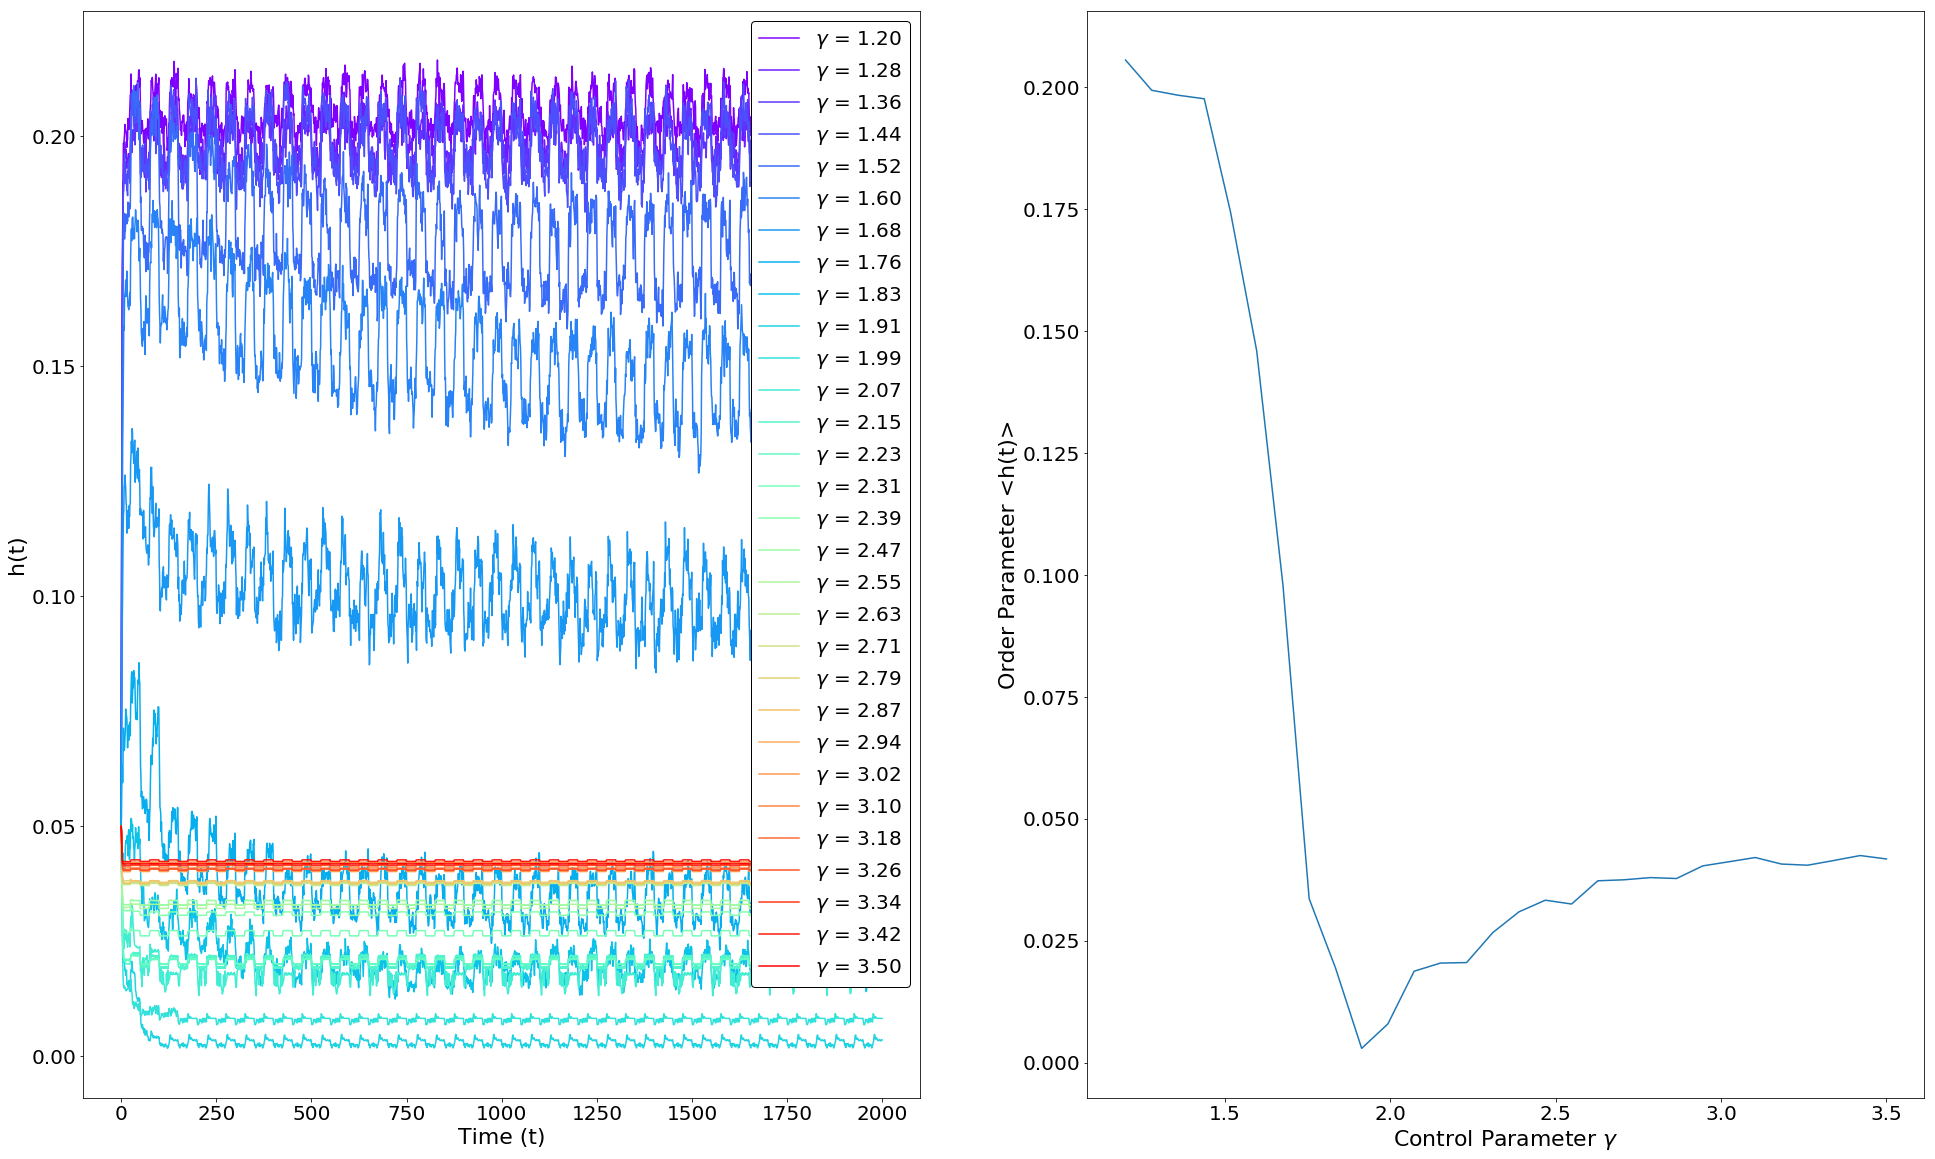

In [9]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=50, trials=20)

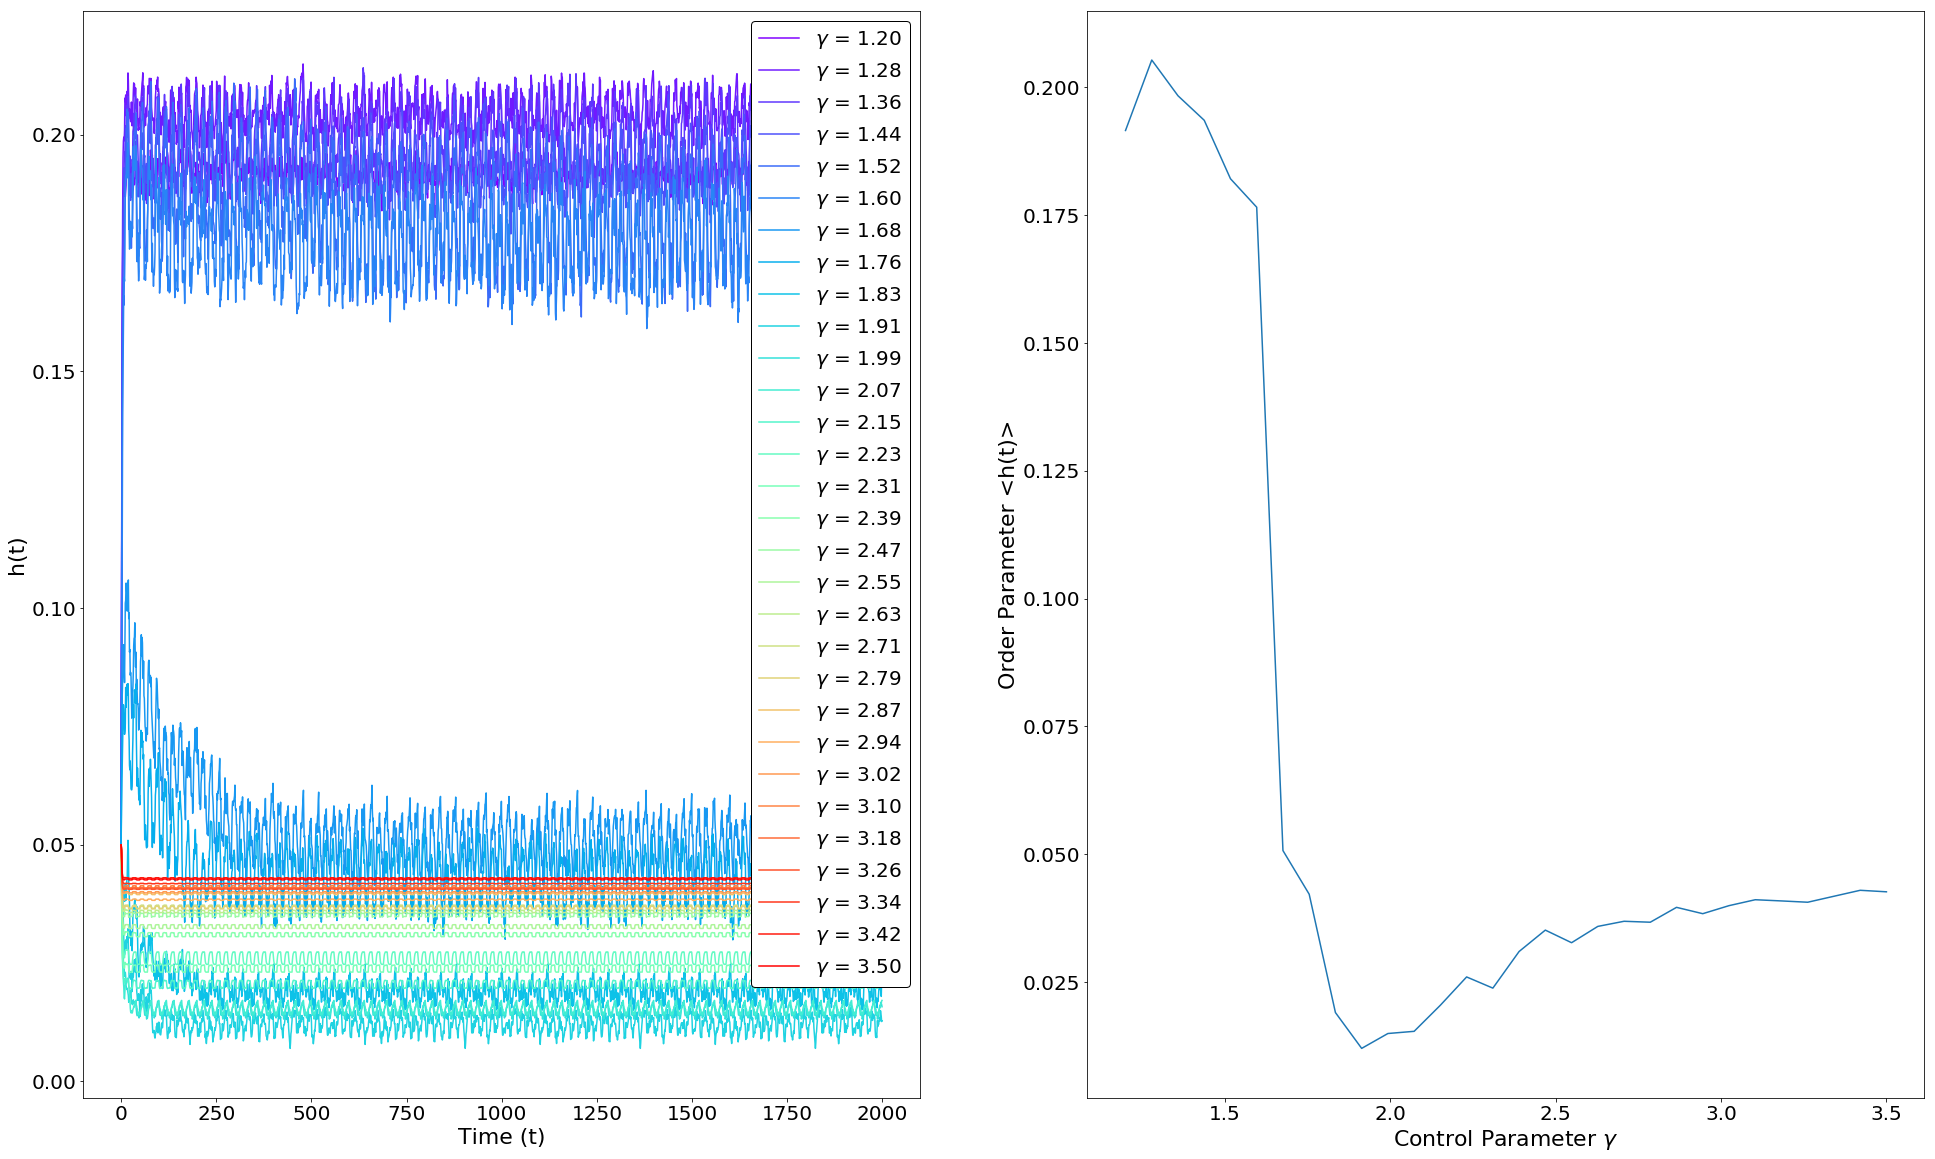

In [10]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=20, trials=20)

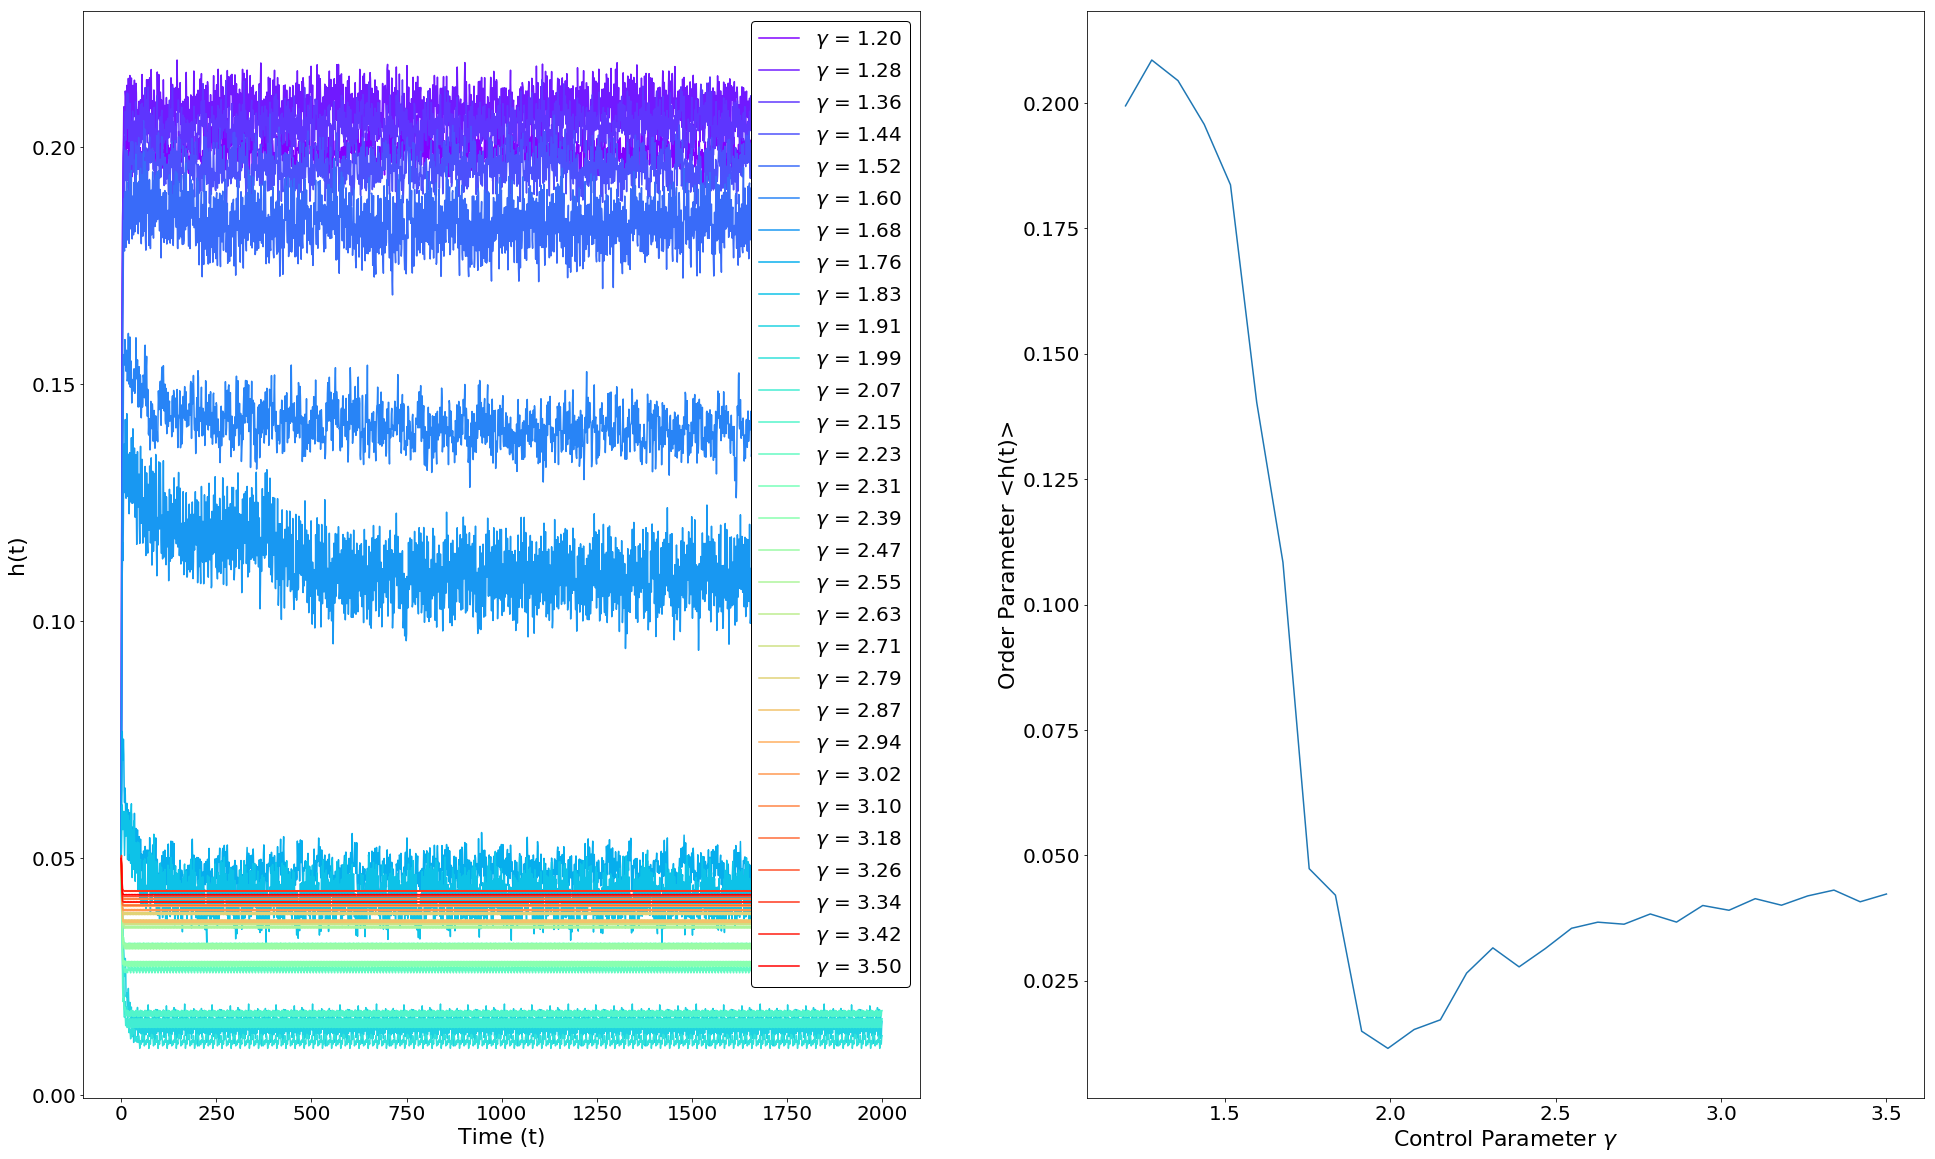

In [11]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=4, trials=20)

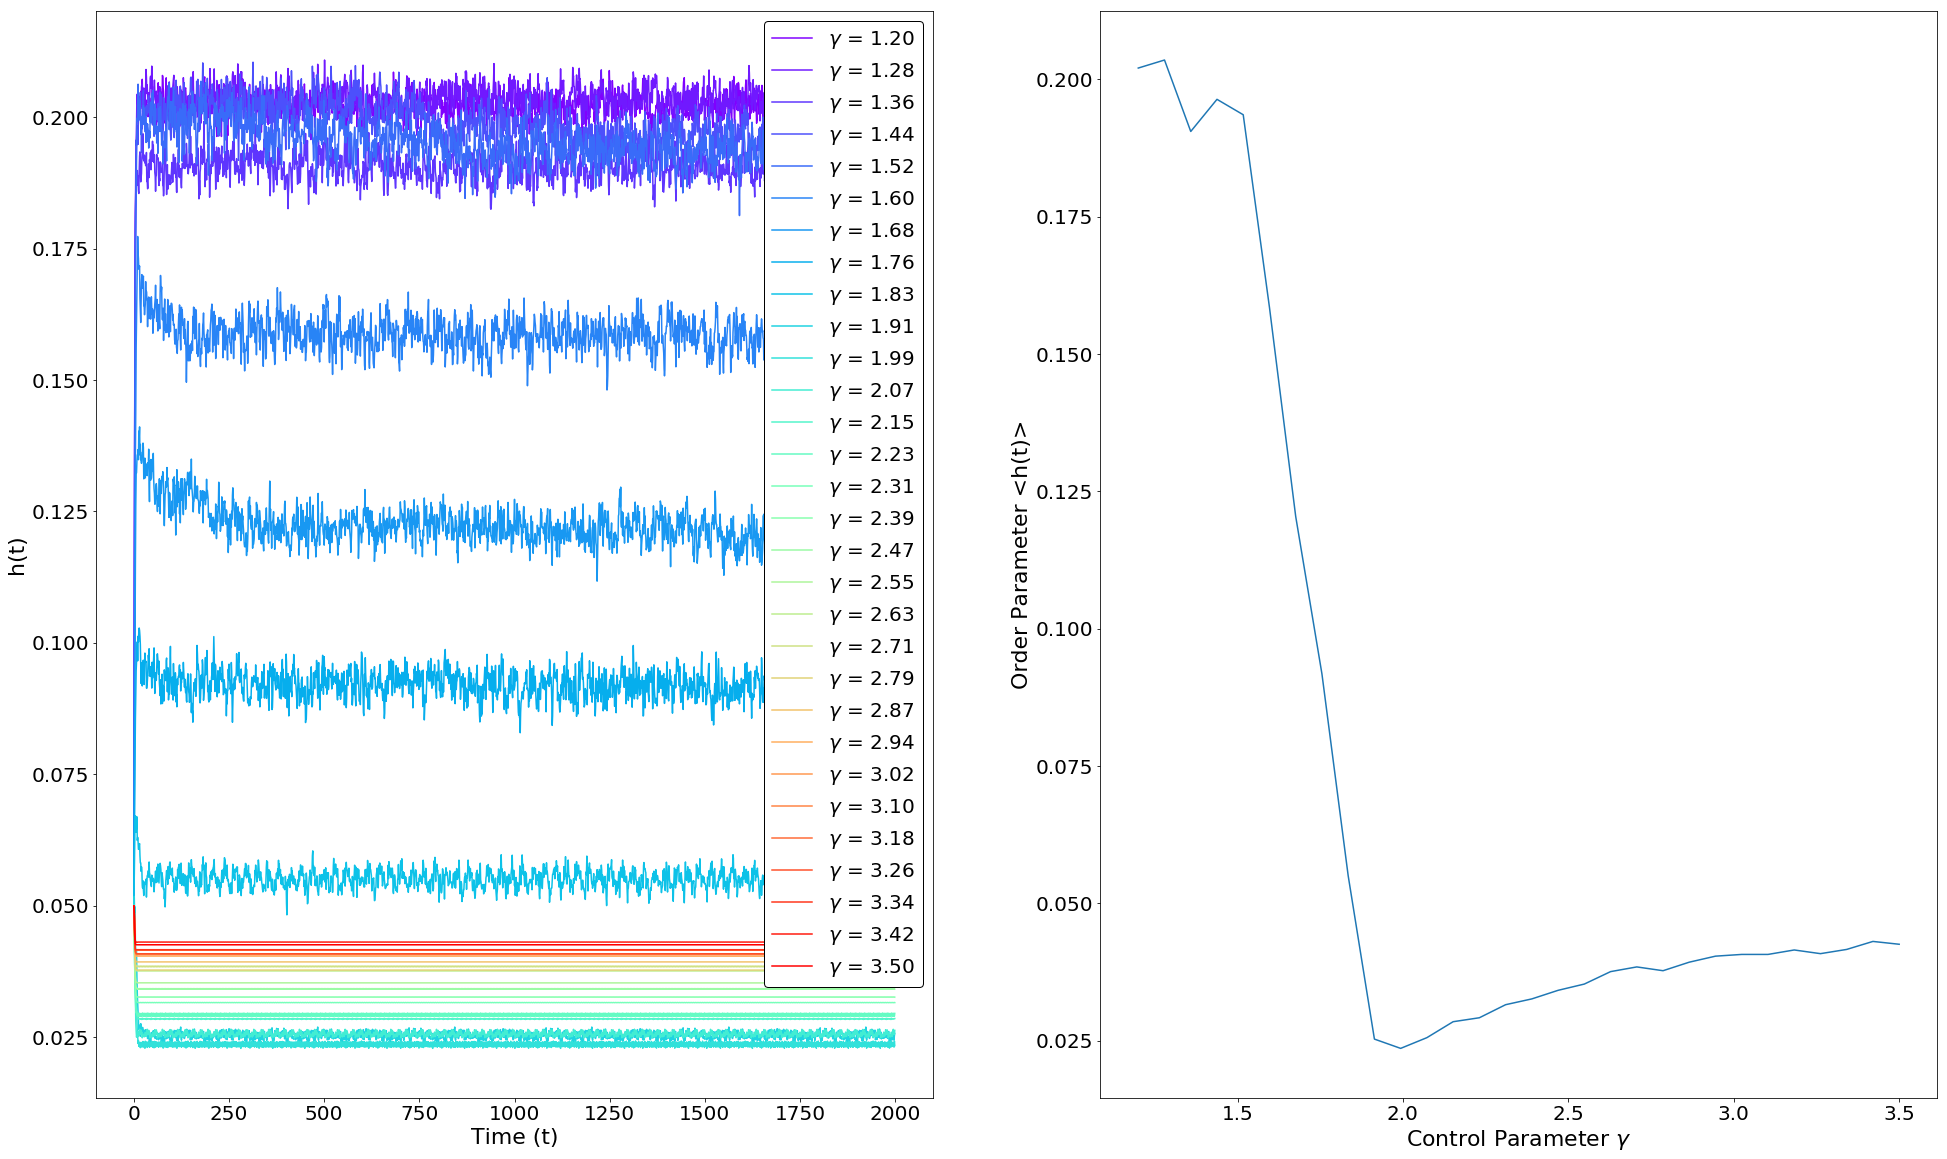

In [12]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=None, trials=20)

## If we've already generated the data...

In [16]:
def remake_graph(file_name="SFHammingOscilResultPer=None.txt"):
    '''
        If we want to make slight changes to the graph... 
    '''
    data_tbl = pd.read_table(file_name, sep="\t", skiprows=1, header=None)
    # data_tbl.index = range(1,21)
    rows, cols = data_tbl.shape
    color = iter(cm.rainbow(np.linspace(0,1,20)))
    myRange = np.linspace(1.5,3.0,20)
    plt.figure(figsize=(33,20))
    plt.subplot(121)
    for i in range(rows):
        c = next(color)
        plt.plot(data_tbl.iloc[i, :], color=c, label=r"$\gamma$ = %.2f" % (myRange[i]))

    legend = plt.legend(frameon=True, framealpha=1)#, bbox_to_anchor=(1.1, 1.05))
    #     plt.title("Average Hamming Distance Hom n=%d, d=%0.2f, t=%d, trials=%d, r=%d" % (n,d,t,trials, networks))
    # plt.title("Random Threshold Network Hamming Distance", size = 34)
    plt.ylabel("h(t)", size = 22)
    plt.xlabel("Time (t)", size = 22)
    # plt.xticks(fontsize=30)
    # plt.yticks(fontsize=25)


    # frame = legend.get_frame()
    # frame.set_facecolor('white')
    # frame.set_edgecolor('black')  

    plt.subplot(122)
    plt.plot(myRange, data_tbl.mean(axis=1))
    # plt.xticks(fontsize=30)
    # plt.yticks(fontsize=25)
    plt.xlabel(r'Control Parameter $\gamma$', size = 22)
    plt.ylabel('Order Parameter <h(t)>', size = 22)
    # plt.title("Ordered-Chaotic Phase Transition", size = 34)
    # plt.subplots_adjust(wspace=0.3)
    plt.show()

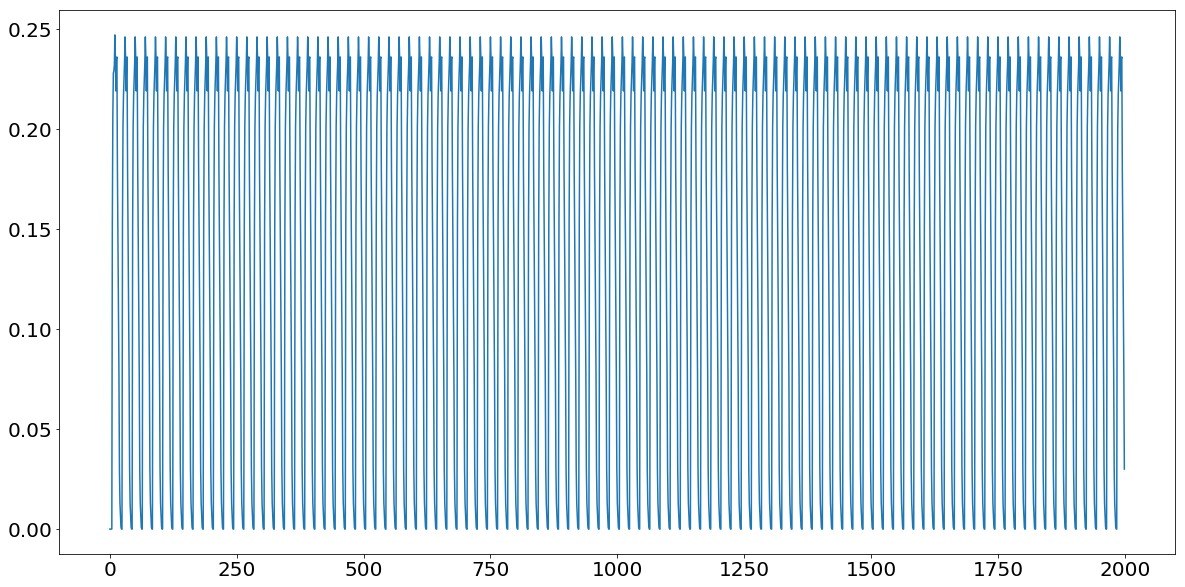

In [136]:
test_graph = SFGraph(1000, 2.0)
start = np.copy(test_graph.get_config())
hub = test_graph.find_hub()

tbl1 = test_graph.oscillate_update(node_index=hub, period=20, time=2000)
test_graph.set_config(np.copy(start))
tbl2 = test_graph.oscillate_update(node_index=hub, period = 10, time=2000)

plt.plot(Graph.hamming_distance_table(tbl1, tbl2))
plt.show()

In [152]:
test_graph.get_config()[1,0]

1

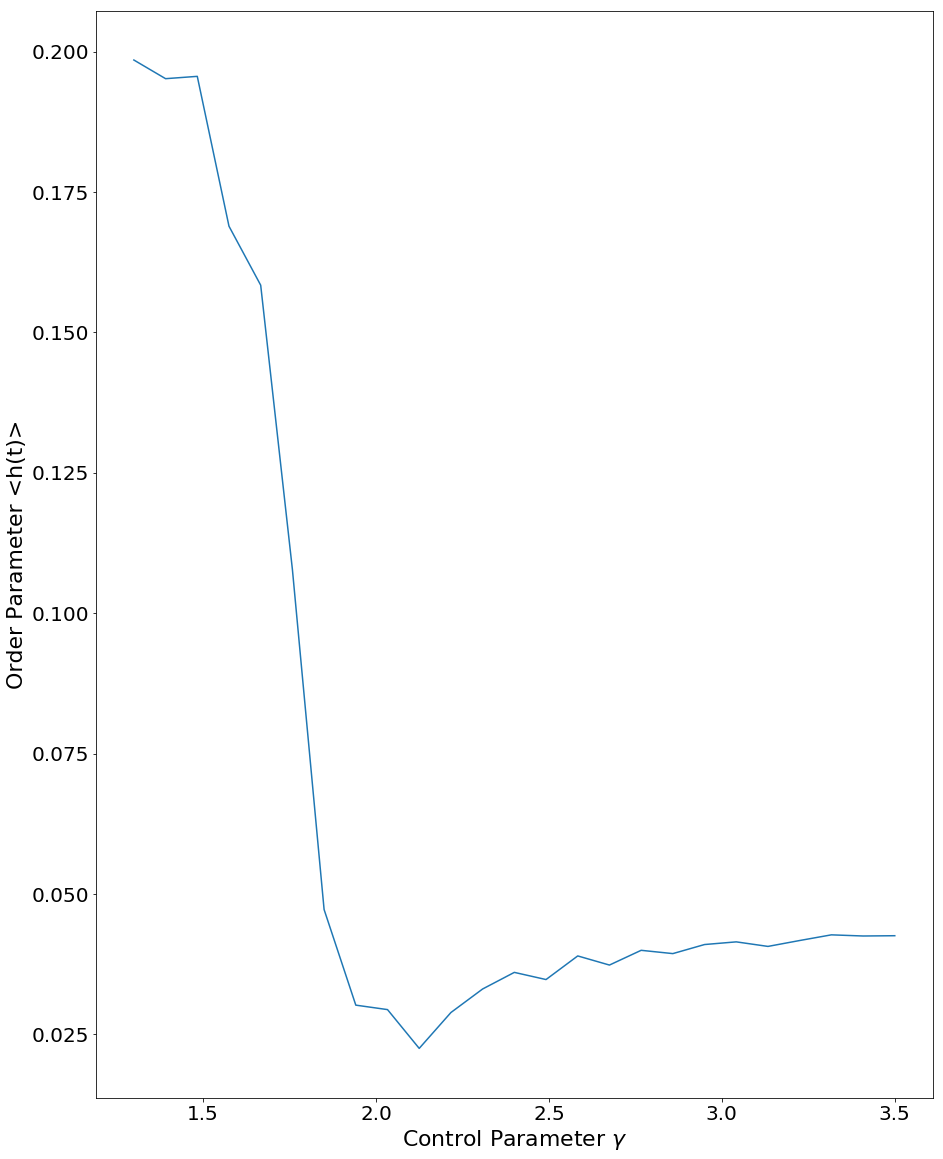

In [15]:
d = 0.05
n = 1000
r = 20
ic = 5
t = 2000 

plt.figure(figsize=(33,20))
# # f = open("SFHammingResult.txt", "w")
# # f.write("Scale Free Network Blocked hub nodes, n = %d, d = %.2f, t = %d, ic = %d, r = %d\n" %(n, d, t, ic, r))
color = iter(cm.rainbow(np.linspace(0,1,25)))
arlist = []
myRange = np.linspace(1.3,3.5,25)
plt.subplot(121)
for gam in myRange:
    arlist.append(SFGraph.avg_hamming_network(lam=gam, size=n, trials=ic, perturb_frac=d, 
                                              time=t, config_prob=0.5, networks=r))            
for i,ar in enumerate(arlist):
    c = next(color)
    plt.plot(ar, color=c, label=r"$\gamma$ = %.2f" % myRange[i])
#     f.write("\t".join([str(j) for j in ar]) + "\n")

# Also tack on the plot for the average of each
legend = plt.legend(frameon=True, framealpha=1)#, bbox_to_anchor=(1.1, 1.05))
plt.ylabel("h(t)", size = 22)
plt.xlabel("Time (t)", size = 22)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
meanAr = []
for ar in arlist:
    # Only taking the mean after t/2
    meanAr.append(np.mean(ar[t//2:]))
plt.subplot(122)
plt.plot(myRange, meanAr)
plt.xlabel(r'Control Parameter $\gamma$', size = 22)
plt.ylabel('Order Parameter <h(t)>', size = 22)
plt.show()
# f.close()


Replot in terms of $K$... 

Replotting for k

In [17]:
trials = 10
myRange = np.linspace(1.2,3.5,30)
out_degree = {j : [] for j in myRange}
in_degree = {j : [] for j in myRange}
for j in myRange:
    for test in range(trials): 
        test_graph = SFGraph(1000, j)
        out_degree[j].append(np.mean(test_graph.out_degree()))
        in_degree[j].append(np.mean(test_graph.in_degree()))



In [18]:
gam_k_map = {}
for j in myRange: 
    gam_k_map[j] = np.mean(out_degree[j])


In [4]:
# ctrl = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=None.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
# per4 = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=4.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
# per20 = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=20.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
# per50 = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=50.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values

prefix = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/NewPhaseDiagram/"



ctrl = pd.read_csv(prefix+"SFHammingOscilResultPer=None.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
per4 = pd.read_csv(prefix+"SFHammingOscilResultPer=4.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
per20 = pd.read_csv(prefix+"SFHammingOscilResultPer=20.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
per50 = pd.read_csv(prefix+"SFHammingOscilResultPer=50.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values






In [5]:
gamma = np.linspace(1.2,3.5,30)

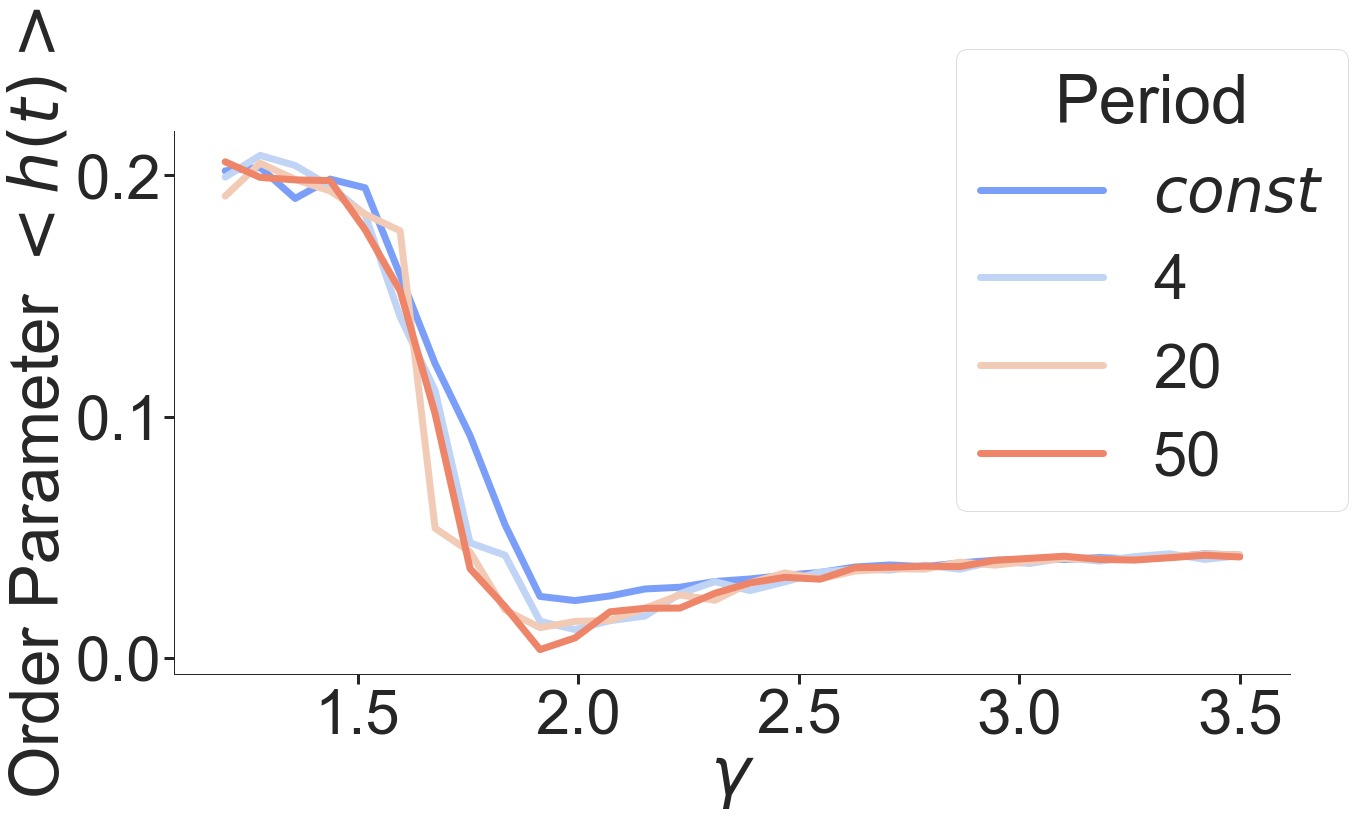

In [20]:
colors = sns.color_palette(palette="coolwarm", n_colors=4)
plt.plot(gamma, ctrl, label="$const$", c= colors[0])
plt.plot(gamma, per4, label="4", c = colors[1])
plt.plot(gamma, per20, label="20", c = colors[2])
plt.plot(gamma, per50, label="50", c = colors[3])
plt.legend(title="Period", loc=(0.7,0.3))
plt.xlabel(r"$\gamma$")
plt.ylabel("Order Parameter $<h(t)>$")
plt.savefig("/Users/Sam/Desktop/phasetransition.pdf", bbox_inches="tight")
plt.show()




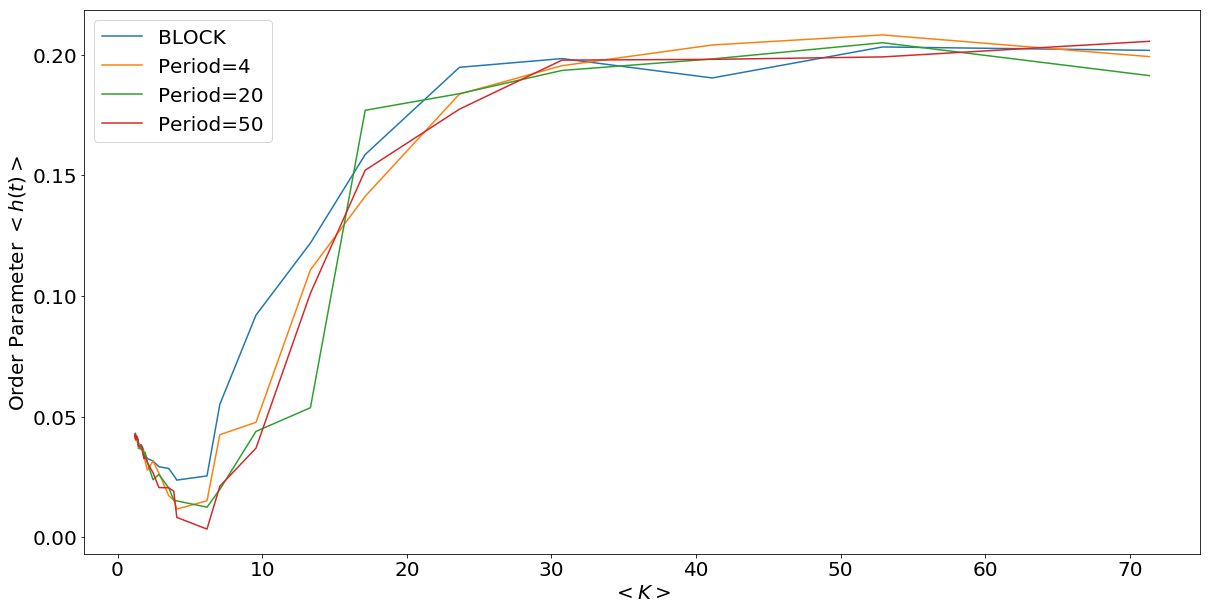

In [19]:
plt.plot([gam_k_map[i] for i in gamma], ctrl, label="BLOCK")
plt.plot([gam_k_map[i] for i in gamma], per4, label="Period=4")
plt.plot([gam_k_map[i] for i in gamma], per20, label="Period=20")
plt.plot([gam_k_map[i] for i in gamma], per50, label="Period=50")
plt.legend()
plt.xlabel(r"$<K>$")
plt.ylabel("Order Parameter $<h(t)>$")
plt.show()



In [20]:
test_graph = SFGraph(1000, 2.0)

## Try this again with homogeneous networks

In [4]:
def avg_oscil_k_hamming(n, k, d, time, period, ic, trials): 
    '''
        For a given k, generate trials networks, 
        do ic initial conditions of each 
    '''
    my_ar = []
    for j in range(trials): 
        my_graph = HomGraph(n, k)
        hub = my_graph.find_hub()
        my_ar.append(calculate_avg_oscil_for_graph(my_graph, d=d, time=time, 
                                      period=period, hub=hub, ic=ic))
    return np.average(my_ar, axis=0)


def avg_block_k_hamming(n, k, d, time, ic, trials): 
    '''
        For a given gamma, generate trials networks, 
        do ic initial conditions of each 
    '''
    my_ar = []
    for j in range(trials): 
        my_graph = HomGraph(n, k)
        hub = my_graph.find_hub()
        my_ar.append(calculate_avg_block_for_graph(my_graph, d=d, time=time,
                                                   hub=hub, ic=ic))
    return np.average(my_ar, axis=0)
        

In [5]:

# Try to write this out to a file


def plot_avg_network_hamming_distances_hom_spectrum(n, ic, d, t, trials, size = 22, period=None,):
    """
        For a spectrum of connectivity parameters plot the avearge hamming distance & control parameter graphs
        Do this for MULTIPLE realizations for each conncetivity parameter. Find hamming distnace for this network over several intiial conditions 
    """
    plt.figure(figsize=(33,20))
    f = open("HomHammingOscilResultPer=%s.txt" % period, "w")
    f.write("Homogeneous Network Blocked hub nodes, n = %d, d = %.2f, t = %d, ic = %d, r = %d, period = %s\n" %(n, d, t, ic, trials, period))
    color = iter(cm.rainbow(np.linspace(0,1,20)))
    arlist = []
    myRange = np.arange(1,21)
    plt.subplot(121)
    for k in myRange:
        if period is None: 
            arlist.append(avg_block_k_hamming(n=n, k=k, d=d, time=t, ic=ic, trials=trials))
        else: 
            arlist.append(avg_oscil_k_hamming(n=n, k=k, d=d, time=t, period=period,
                                                  ic=ic, trials=trials))            
    for i,ar in enumerate(arlist):
        c = next(color)
        f.write("\t".join([str(j) for j in ar]) + "\n")
        plt.plot(ar, color=c, label=r"$\langle K\rangle$ = %d" % myRange[i])
        
    # Also tack on the plot for the average of each
    legend = plt.legend(frameon=True, framealpha=1)#, bbox_to_anchor=(1.1, 1.05))
    plt.ylabel("h(t)", size = 22)
    plt.xlabel("Time (t)", size = 22)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    meanAr = []
    for ar in arlist:
        # Only taking the mean after t/2
        meanAr.append(np.mean(ar[t//2:]))
    plt.subplot(122)
    plt.plot(myRange, meanAr)
    plt.xlabel(r'Control Parameter $<K>$', size = 22)
    plt.ylabel('Order Parameter <h(t)>', size = 22)
    plt.show()
    f.close()

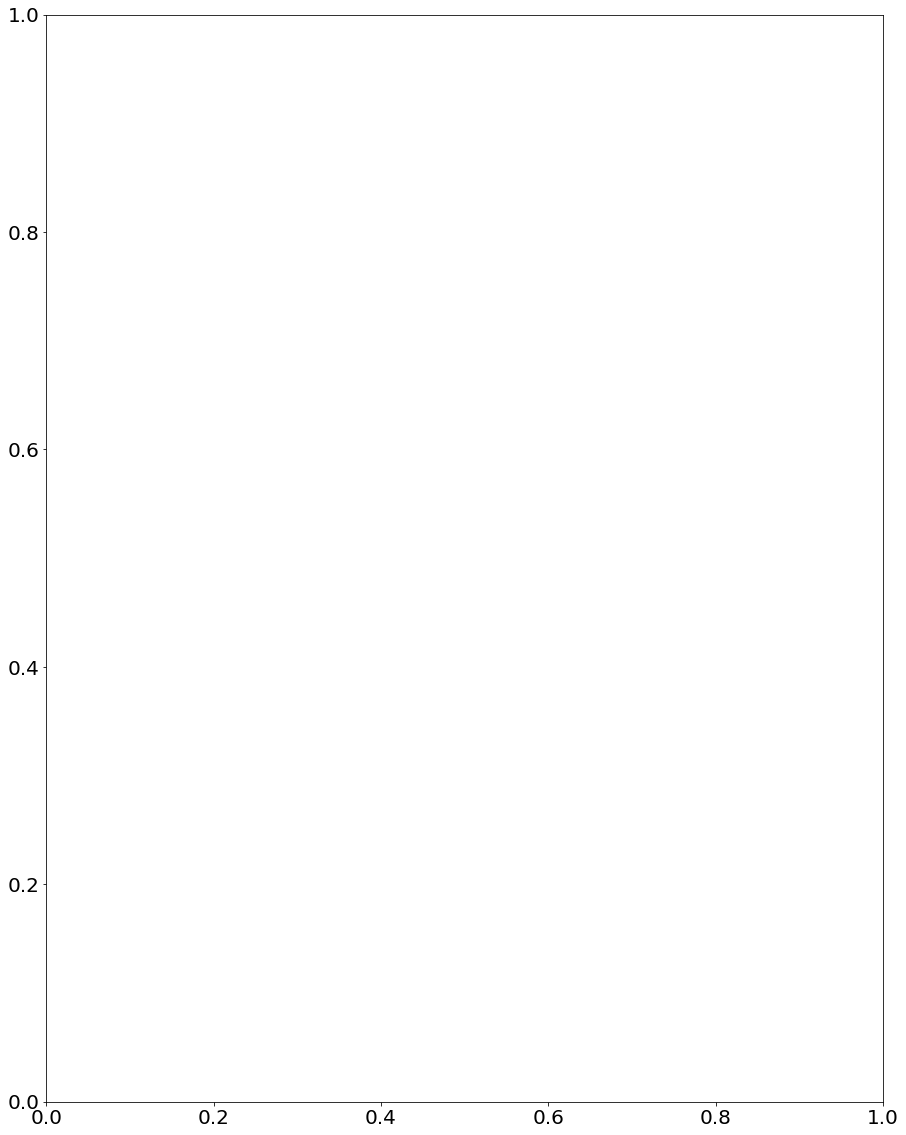

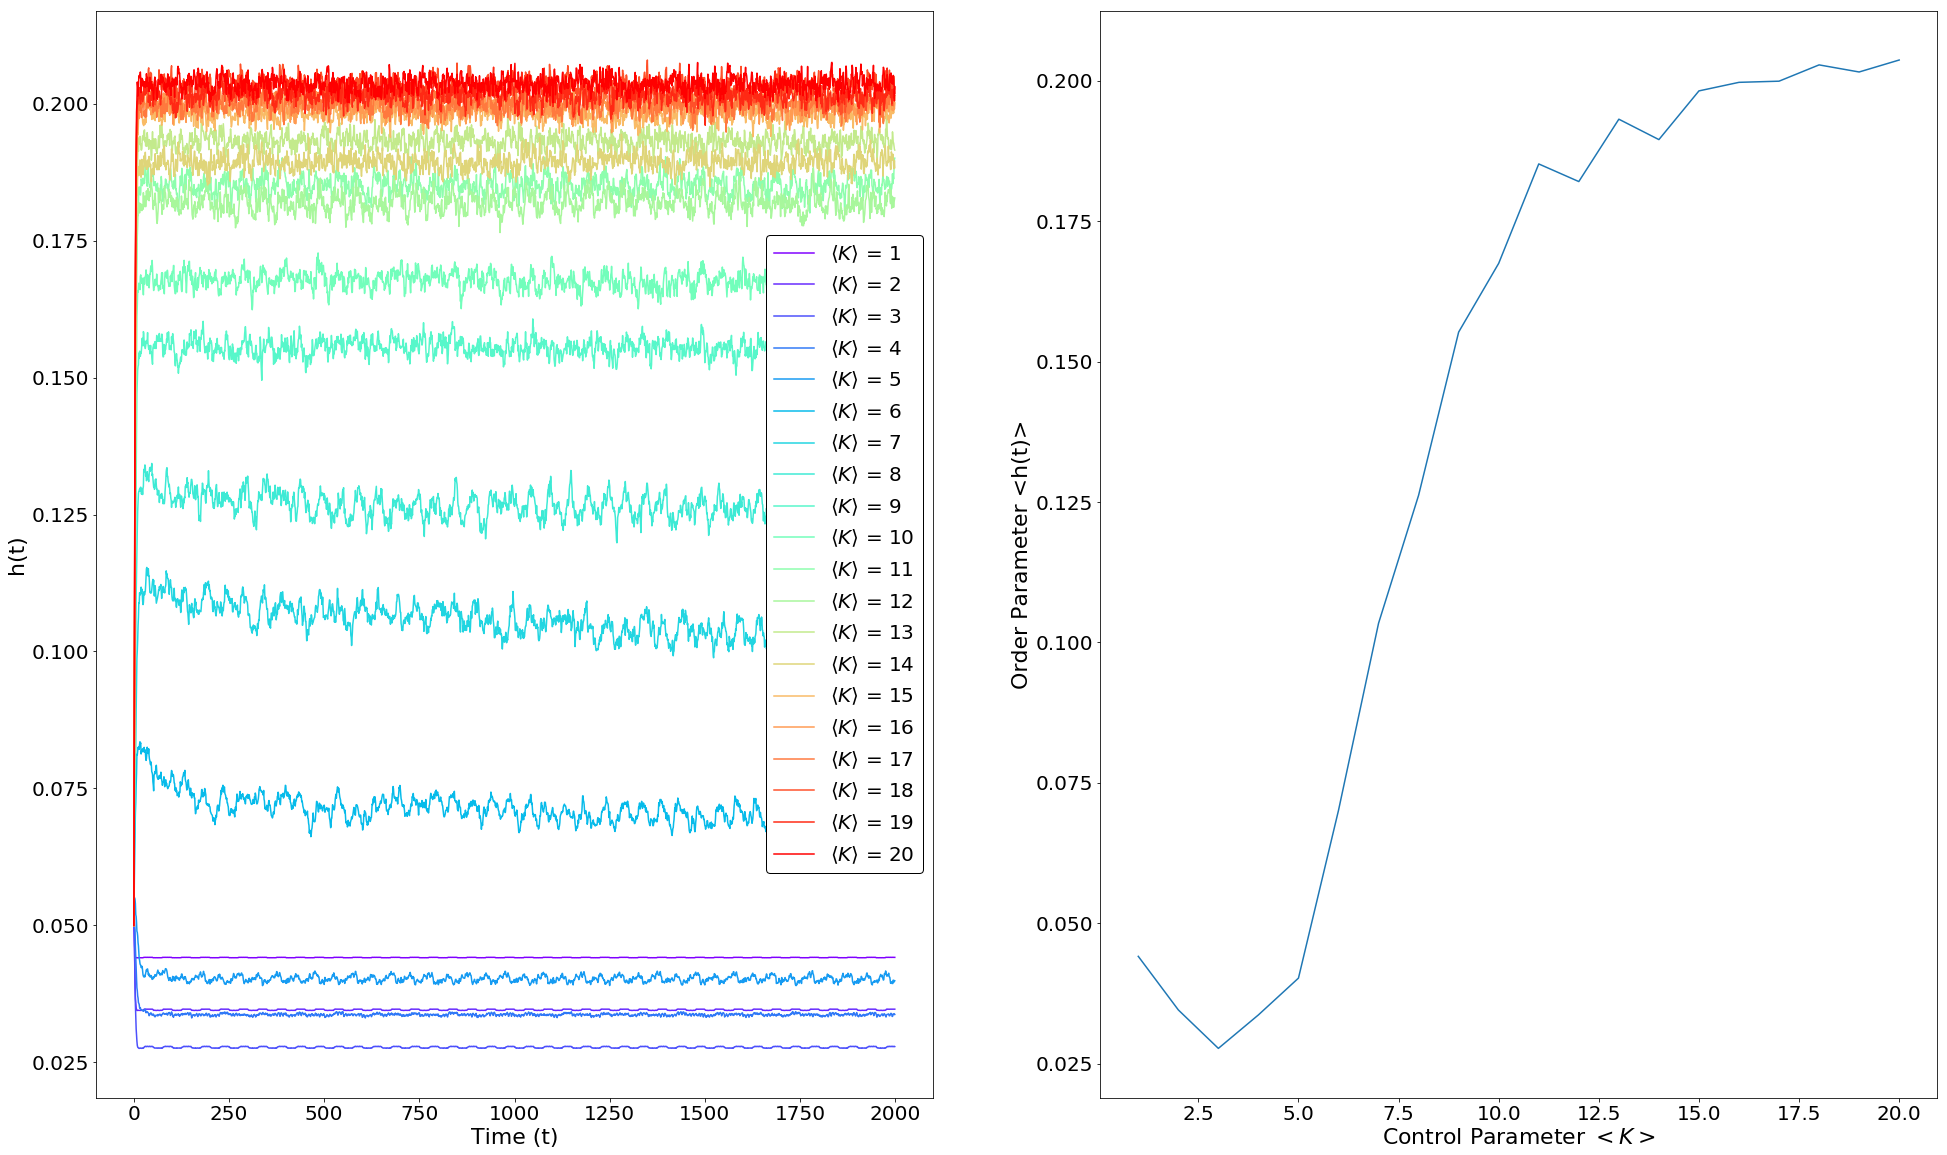

In [16]:
plot_avg_network_hamming_distances_hom_spectrum(n=1000, ic=5, d=0.05, t=2000, period=50, trials=20)

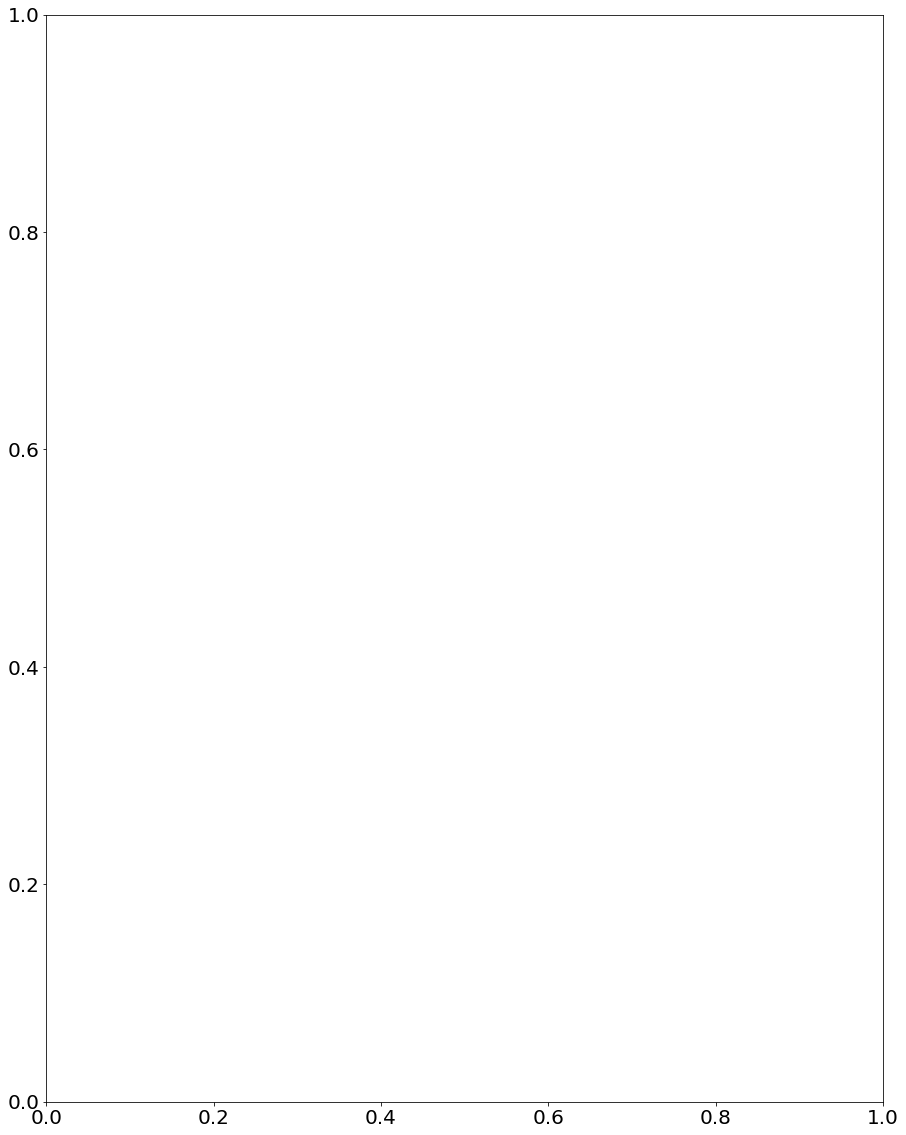

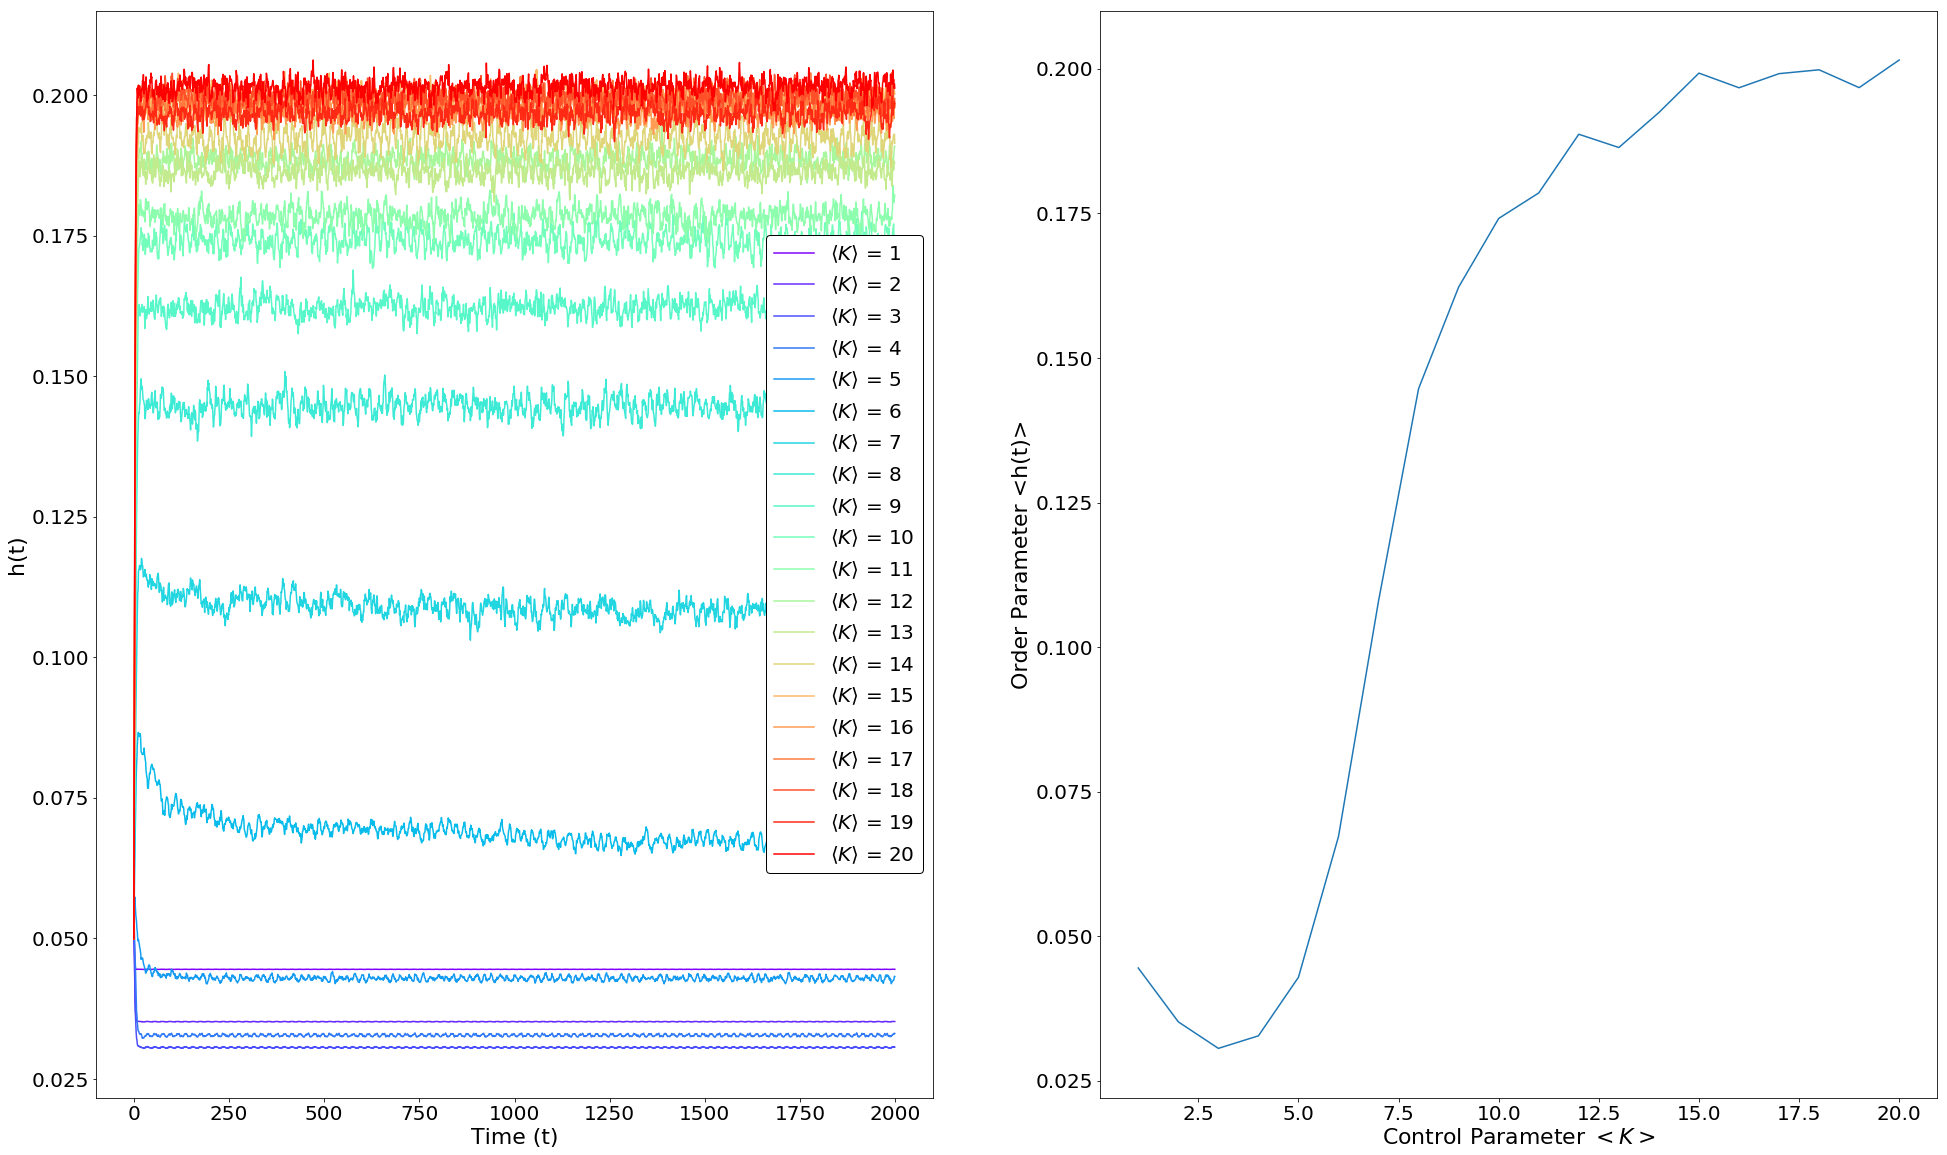

In [10]:
plot_avg_network_hamming_distances_hom_spectrum(n=1000, ic=5, d=0.05, t=2000, period=20, trials=20)

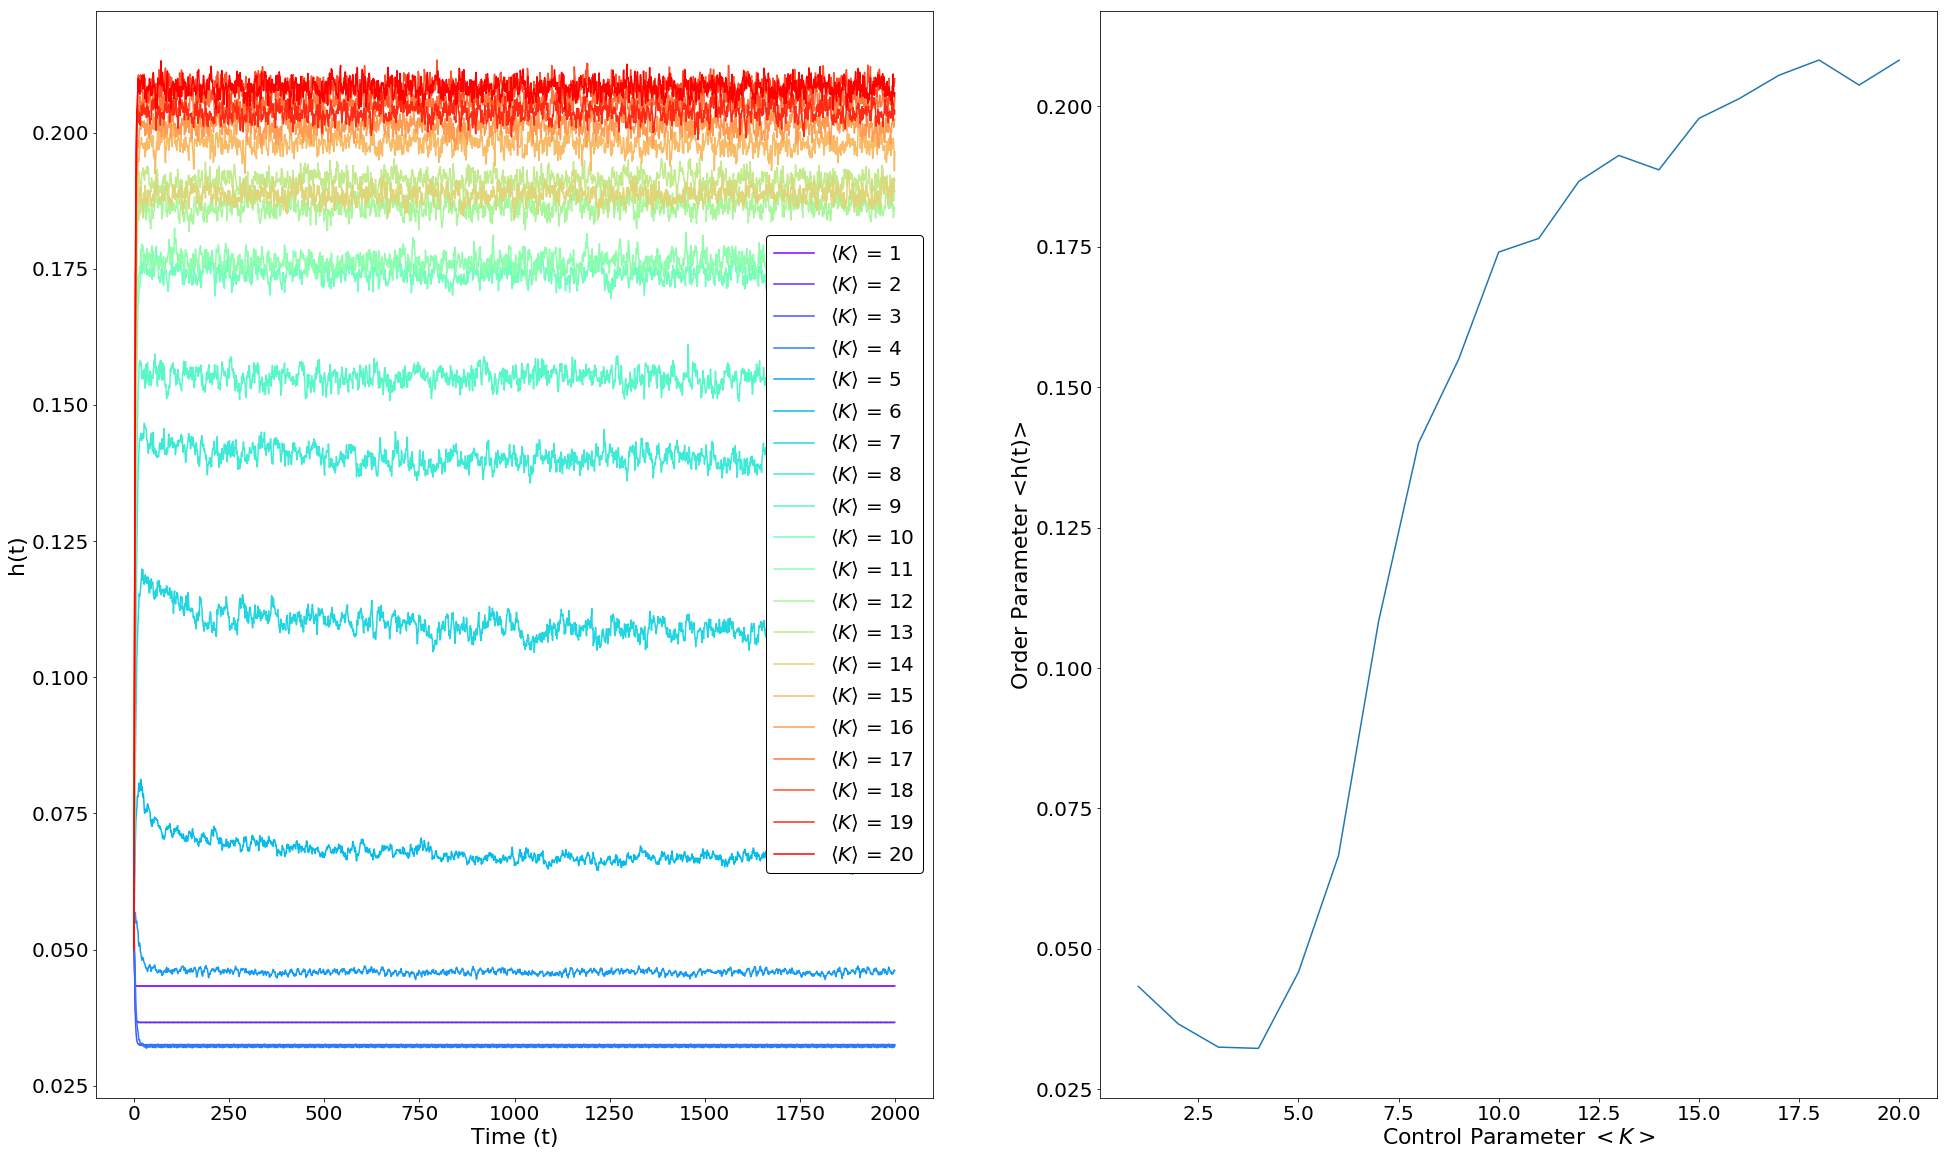

In [18]:
plot_avg_network_hamming_distances_hom_spectrum(n=1000, ic=5, d=0.05, t=2000, period=4, trials=20)

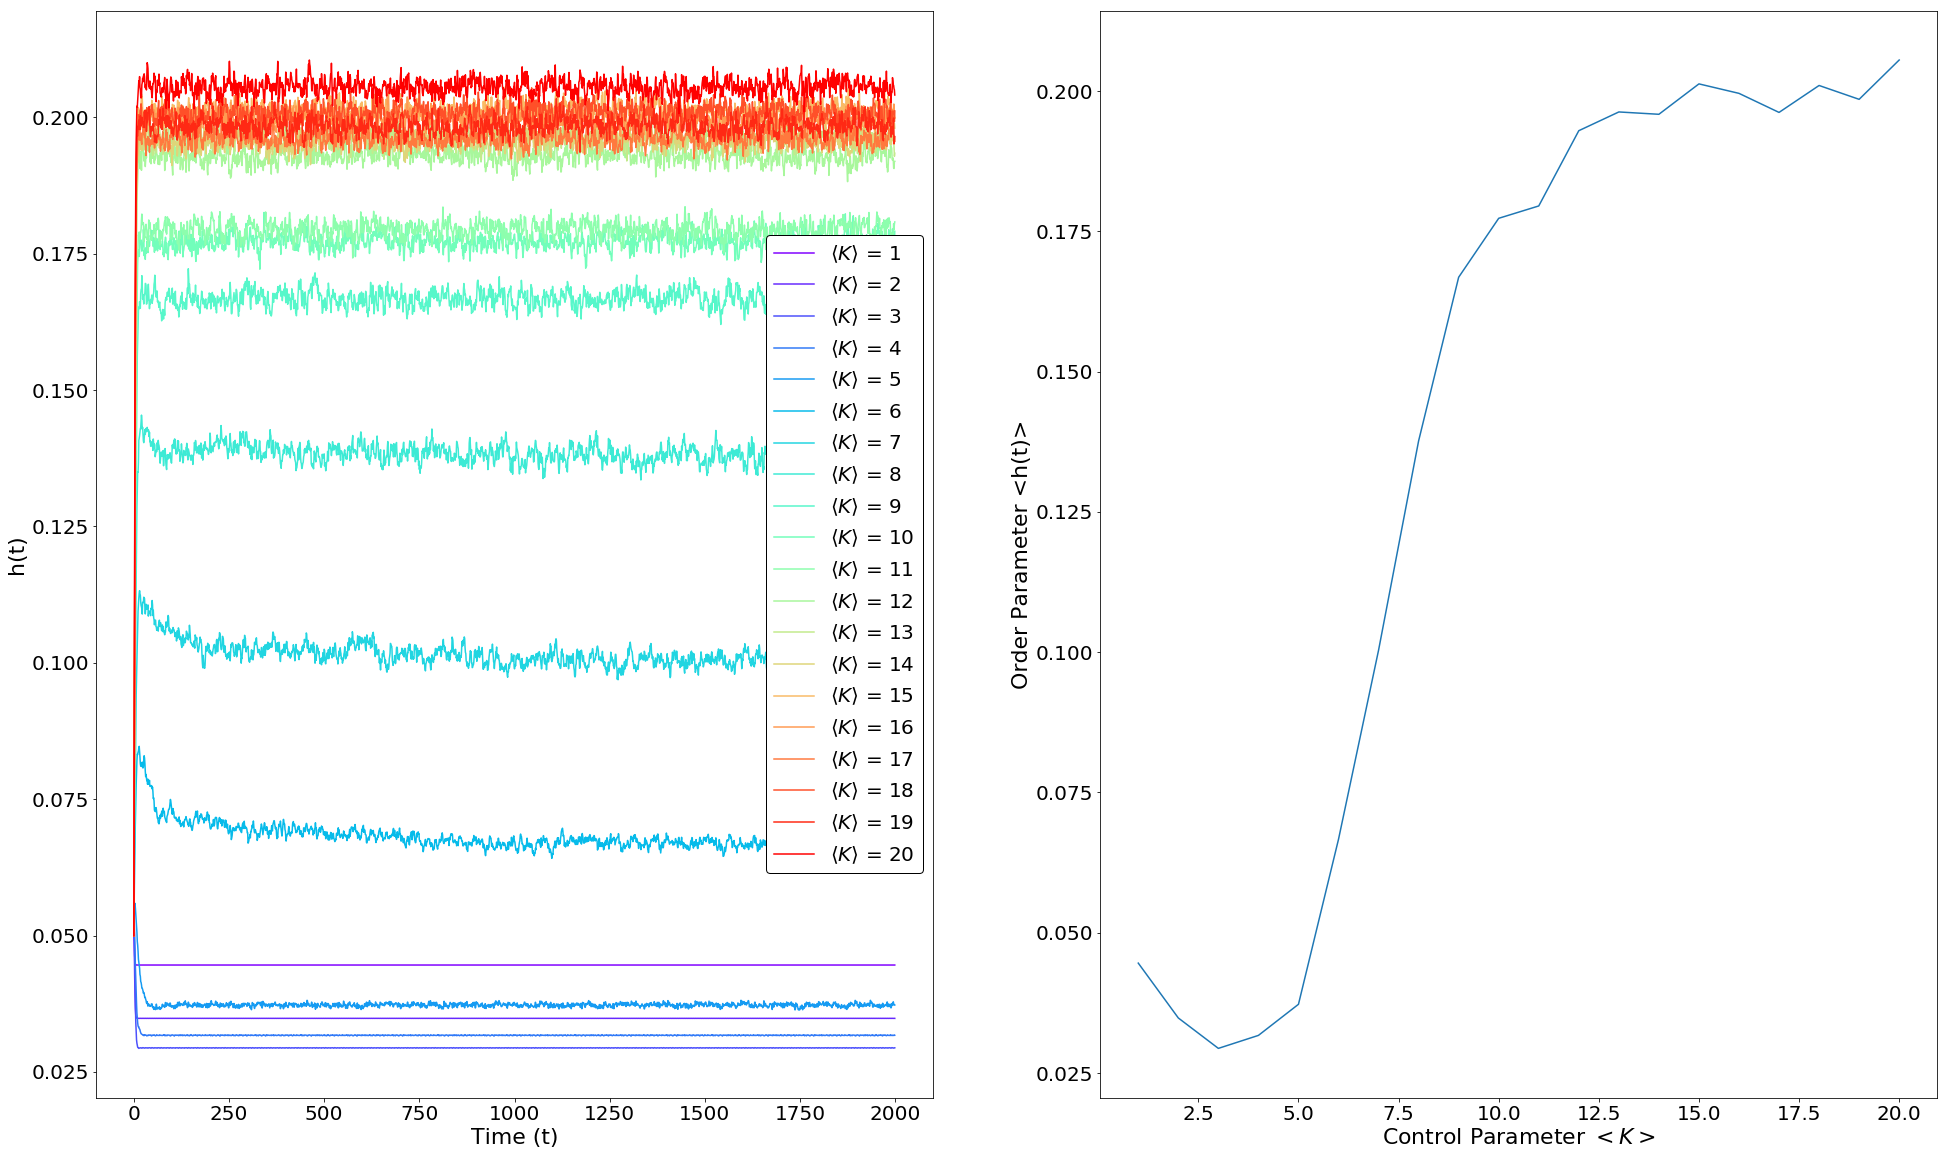

In [19]:
plot_avg_network_hamming_distances_hom_spectrum(n=1000, ic=5, d=0.05, t=2000, period=None, trials=20)

In [ ]:
plot_avg_network_hamming_distances_hom_spectrum(n=50, ic=5, d=0.05, t=2000, period=None, trials=5)

In [11]:
sys.path.append("../../Results/Oscillating/NewPhaseDiagram/")

In [14]:
ls "../../Results/Oscillating/NewPhaseDiagram/"

20.png                             HomogeneousOrderOscil.png
4.png                              None.png
50.png                             OrderParameterNetwork.png
HammingDistanceDiagram.png         OrderParameterNetworkK.png
HammingDistanceDiagram.svg         PreDistributionCorrection/
HomHammingOscilResultPer=20.txt    SFHammingOscilResultPer=20.txt
HomHammingOscilResultPer=4.txt     SFHammingOscilResultPer=4.txt
HomHammingOscilResultPer=50.txt    SFHammingOscilResultPer=50.txt
HomHammingOscilResultPer=None.txt  SFHammingOscilResultPer=None.txt


In [15]:
# ctrl = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=None.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
# per4 = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=4.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
# per20 = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=20.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
# per50 = pd.read_csv("../../Results/Oscillating/NewPhaseDiagram/SFHammingOscilResultPer=50.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values

ctrl = pd.read_csv("HomHammingOscilResultPer=None.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
per4 = pd.read_csv("HomHammingOscilResultPer=4.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
per20 = pd.read_csv("HomHammingOscilResultPer=20.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
per50 = pd.read_csv("HomHammingOscilResultPer=50.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values







FileNotFoundError: File b'HomHammingOscilResultPer=None.txt' does not exist

In [21]:
k = np.arange(1,21)

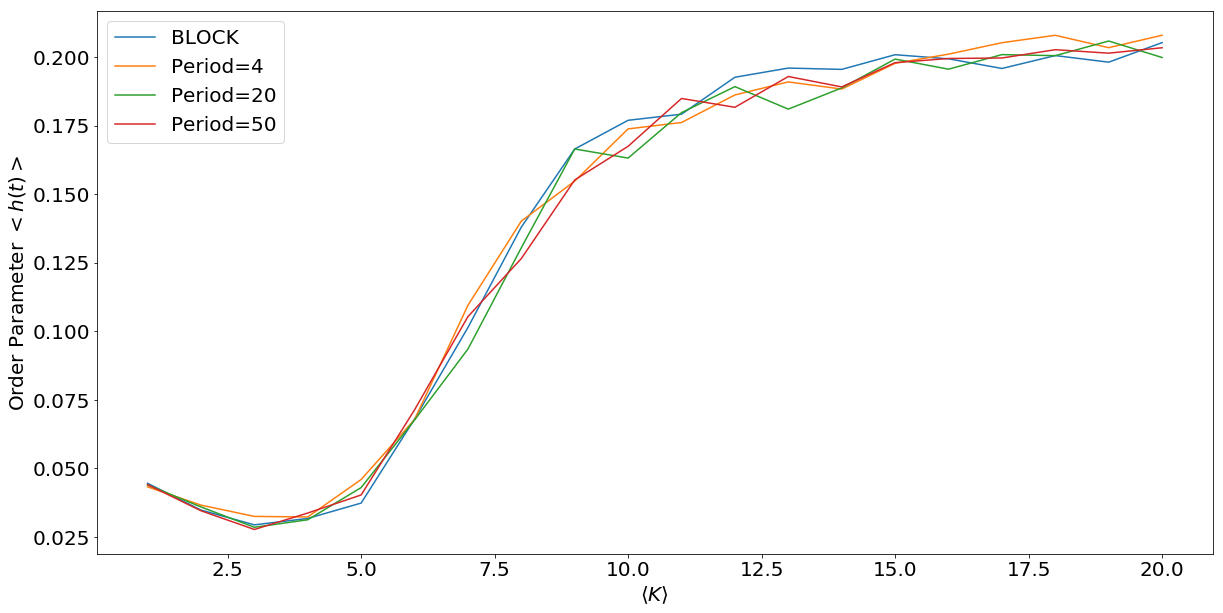

In [23]:
plt.plot(k, ctrl, label="BLOCK")
plt.plot(k, per4, label="Period=4")
plt.plot(k, per20, label="Period=20")
plt.plot(k, per50, label="Period=50")
plt.legend()
plt.xlabel(r"$\langle K\rangle$")
plt.ylabel("Order Parameter $<h(t)>$")
plt.show()



## Try hamming adjustment to view damage spreading...

In [14]:
def oscil_hamming(graph, d, time, period, hub): 
    '''
        Perturb fraction 'd' of the nodes in graph
        Oscillate hub=hub at period=period for time=time
        Return hamming distance bewteen perturb trajectory and original
    '''
    
    start_config = np.copy(graph.get_config())
    start_state = start_config[hub, 0]


    tbl1 = graph.oscillate_update(force_start_on=True, 
                                  node_index=hub, period=period, 
                                  time = 2000)

    graph.set_config(np.copy(start_config))

    tbl2 = graph.update_return_table_blocked(state=start_state, 
                                             node=hub, time = 2000)
    
    
    return Graph.hamming_distance_table(tbl1, tbl2)



def avg_graph(graph, d, time, period, hub, ic): 
    '''
        For some number of initial conditions
        Calculate h(t) 
    '''
    my_ar = []
    for j in range(ic): 
        graph.random_config()
        my_ar.append(oscil_hamming(graph, d, time, 
                                               period, hub))
    return np.average(my_ar, axis=0)



def avg_oscil_gamma_hamming(n, gamma, d, time, period, ic, trials, hub_index=0): 
    '''
        For a given gamma, generate trials networks, 
        do ic initial conditions of each 
    '''
    my_ar = []
    for j in range(trials): 
        my_graph = SFGraph(n, gamma)
        hub = my_graph.find_hub(hub_index)
        my_ar.append(avg_graph(my_graph, d=d, time=time, 
                                      period=period, hub=hub, ic=ic))
    return np.average(my_ar, axis=0)




# Try to write this out to a file


def plot_avg_network_hamming_distances_sf_spectrum(n, ic, d, t, trials, size = 22, hub_index=0, period=None):
    """
        For a spectrum of connectivity parameters plot the avearge hamming distance & control parameter graphs
        Do this for MULTIPLE realizations for each conncetivity parameter. Find hamming distnace for this network over several intiial conditions 
    """
    plt.figure(figsize=(33,20))
    f = open("SFHammingOscilShiftingHubPer=%sHub=%d.txt" % (period, hub_index), "w")
    f.write("Scale Free Network Blocked hub nodes, n = %d, d = %.2f, t = %d, ic = %d, r = %d, period = %s, hub_index=%d\n" %(n, d, t, ic, trials, period, hub_index))
    color = iter(cm.rainbow(np.linspace(0,1,30)))
    arlist = []
    myRange = np.linspace(1.2,3.5,30)
    plt.subplot(121)
    for gam in myRange:
        arlist.append(avg_oscil_gamma_hamming(n=n, gamma=gam, d=d, time=t, period=period,
                                                  ic=ic, trials=trials, hub_index=hub_index))            
    for i,ar in enumerate(arlist):
        c = next(color)
        f.write("\t".join([str(j) for j in ar]) + "\n")
        plt.plot(ar, color=c, label=r"$\gamma$ = %.2f" % myRange[i])
        
    # Also tack on the plot for the average of each
    legend = plt.legend(frameon=True, framealpha=1)#, bbox_to_anchor=(1.1, 1.05))
    plt.ylabel("h(t)", size = 22)
    plt.xlabel("Time (t)", size = 22)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    meanAr = []
    for ar in arlist:
        # Only taking the mean after t/2
        meanAr.append(np.mean(ar[t//2:]))
    plt.subplot(122)
    plt.plot(myRange, meanAr)
    plt.xlabel(r'Control Parameter $\gamma$', size = 22)
    plt.ylabel('Order Parameter <h(t)>', size = 22)
    plt.show()
    f.close()

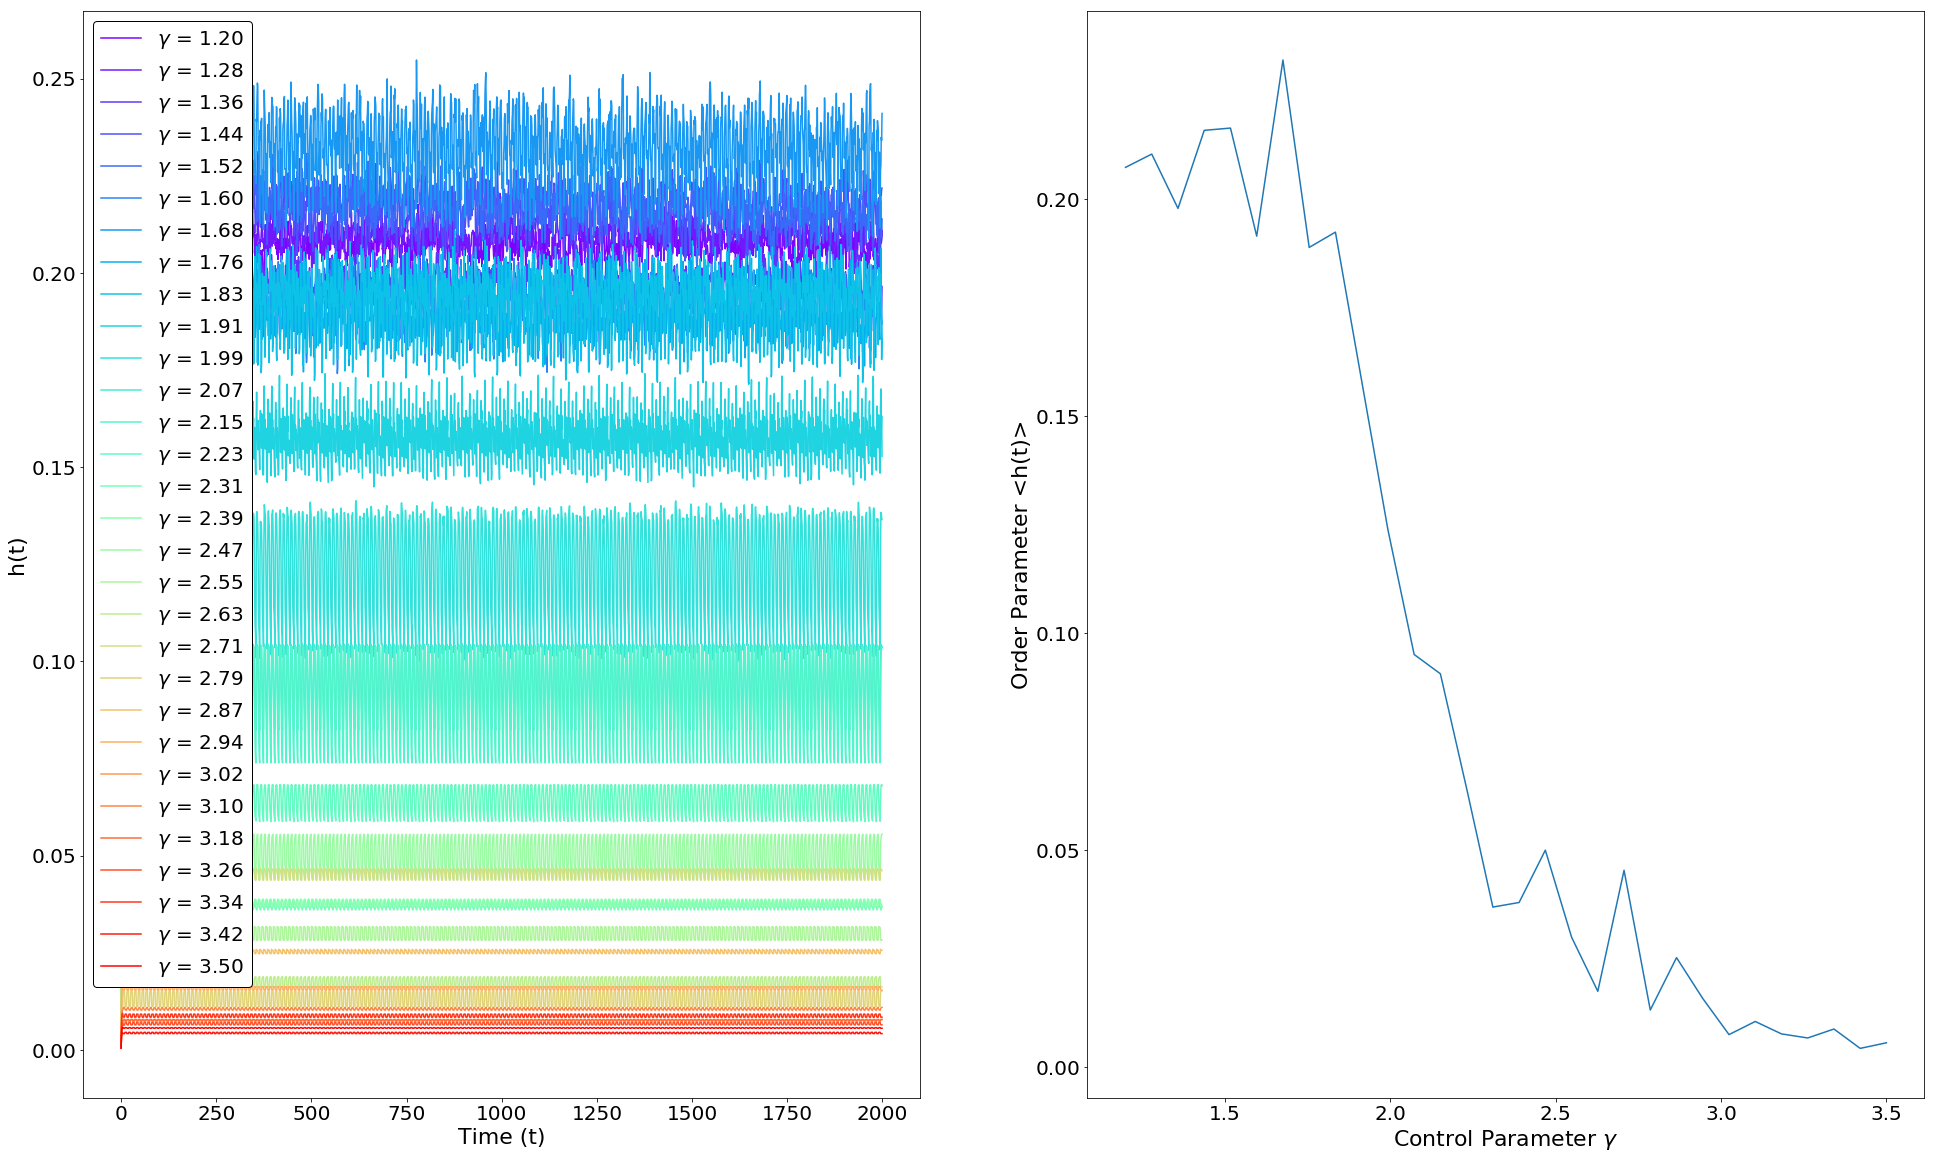

In [16]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=10, trials=10, hub_index=0)

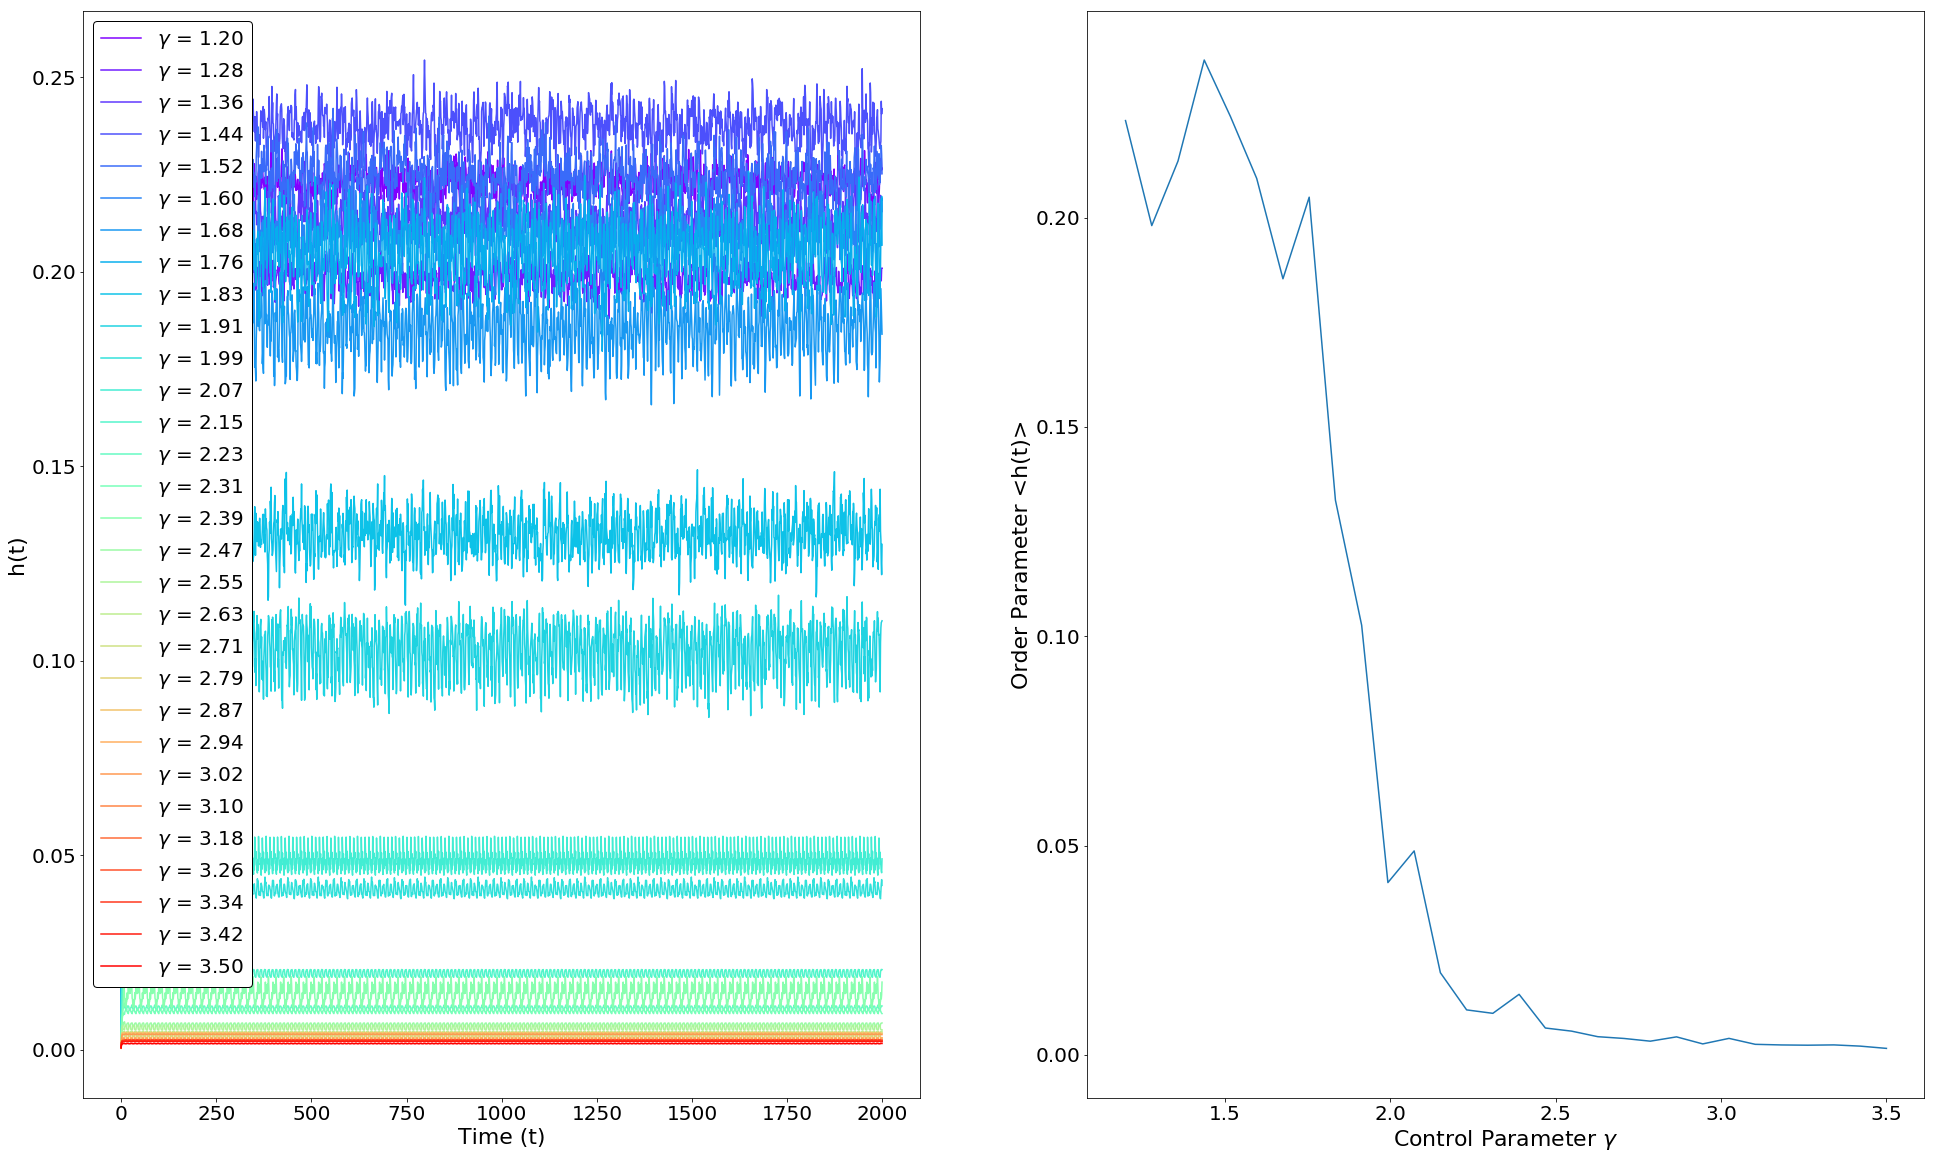

In [17]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=10, trials=10, hub_index=5)

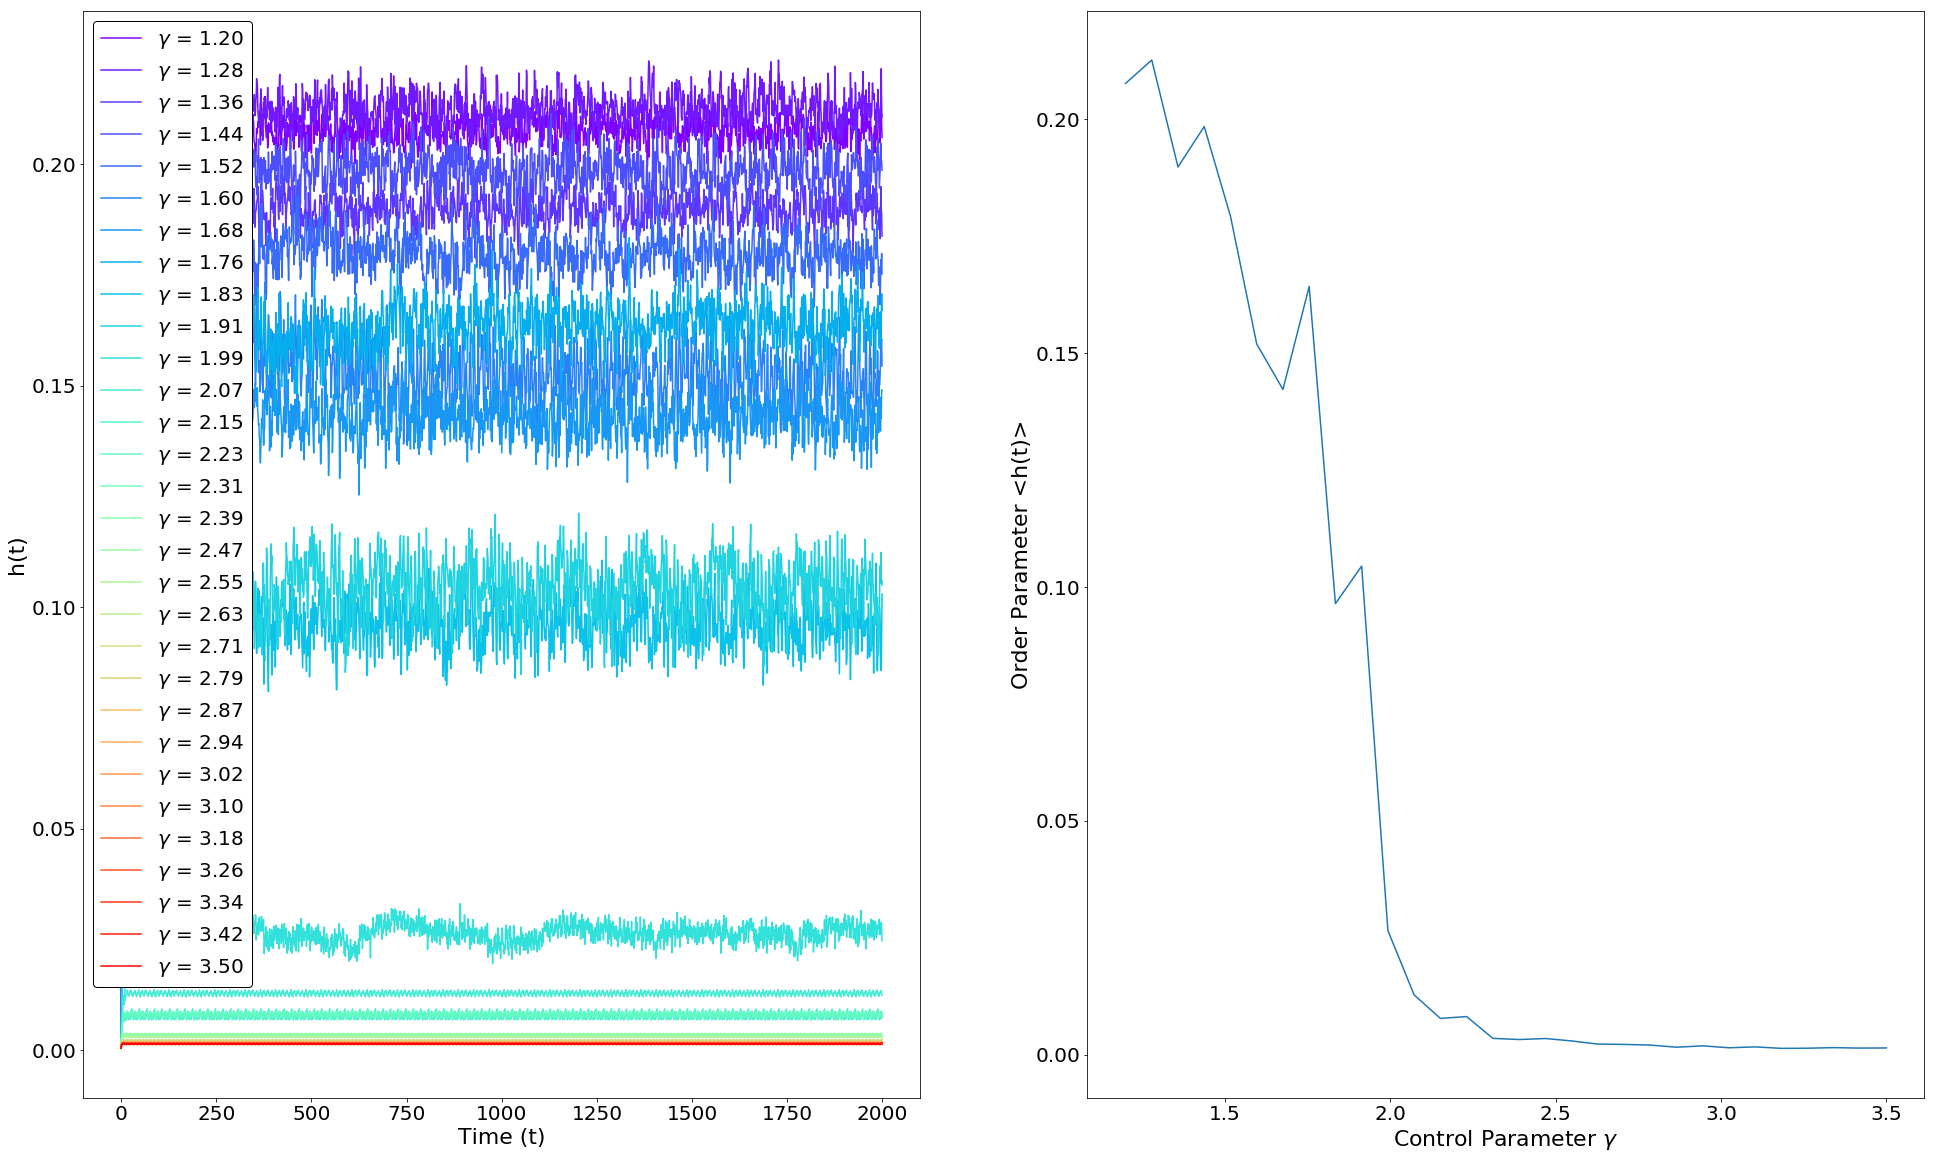

In [18]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=10, trials=10, hub_index=20)

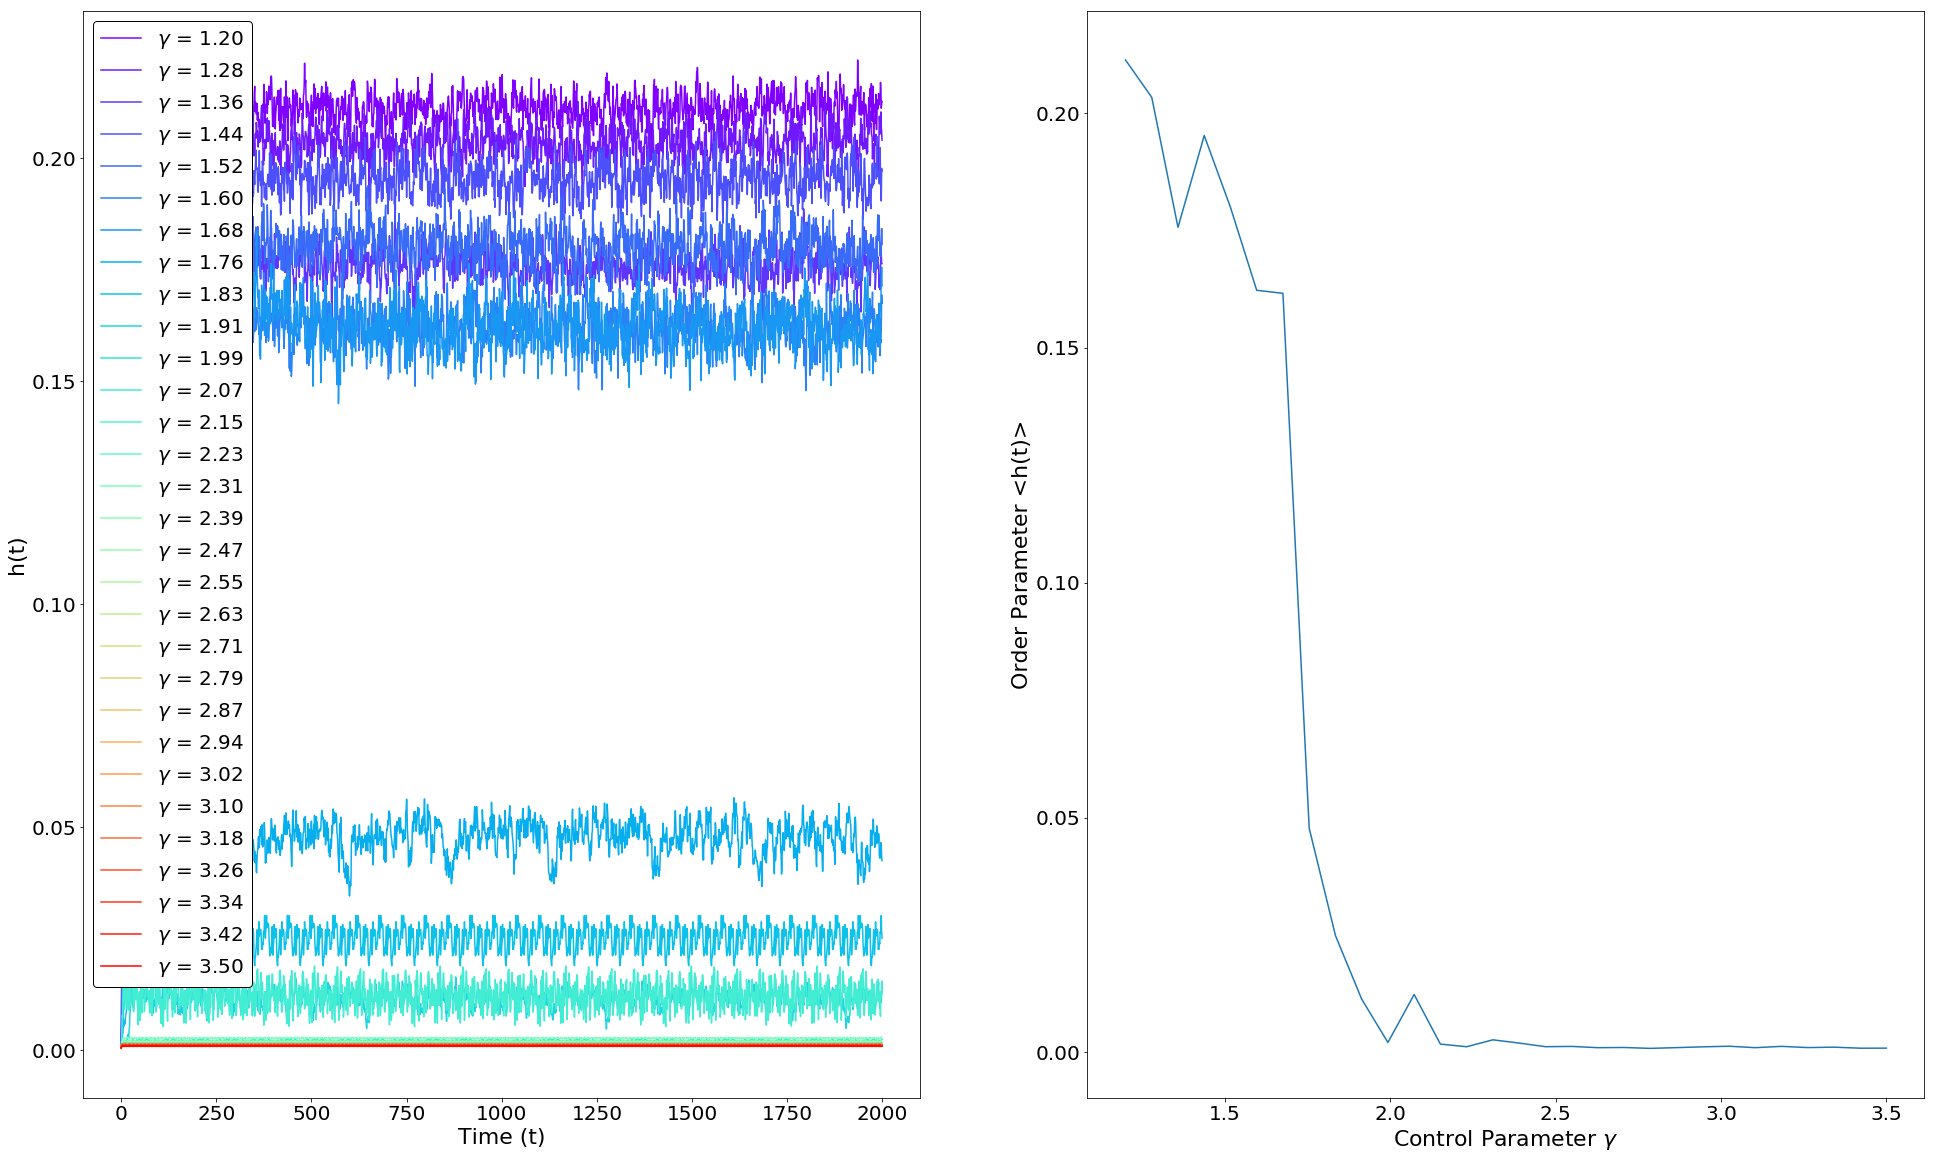

In [19]:
plot_avg_network_hamming_distances_sf_spectrum(n=1000, ic=5, d=0.05, t=2000, period=10, trials=10, hub_index=100)

In [3]:


hub0 = pd.read_csv("SFHammingOscilShiftingHubPer=10Hub=0.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
hub5 = pd.read_csv("SFHammingOscilShiftingHubPer=10Hub=5.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
hub20 = pd.read_csv("SFHammingOscilShiftingHubPer=10Hub=20.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values
hub100 = pd.read_csv("SFHammingOscilShiftingHubPer=10Hub=100.txt", skiprows=1, sep="\t", header=None).mean(axis=1).values







FileNotFoundError: File b'/Users/Sam/Documents/Harvard/Research/Results/Oscillating/NewPhaseDiagram/SFHammingOscilShiftingHubPer=10Hub=0.txt' does not exist

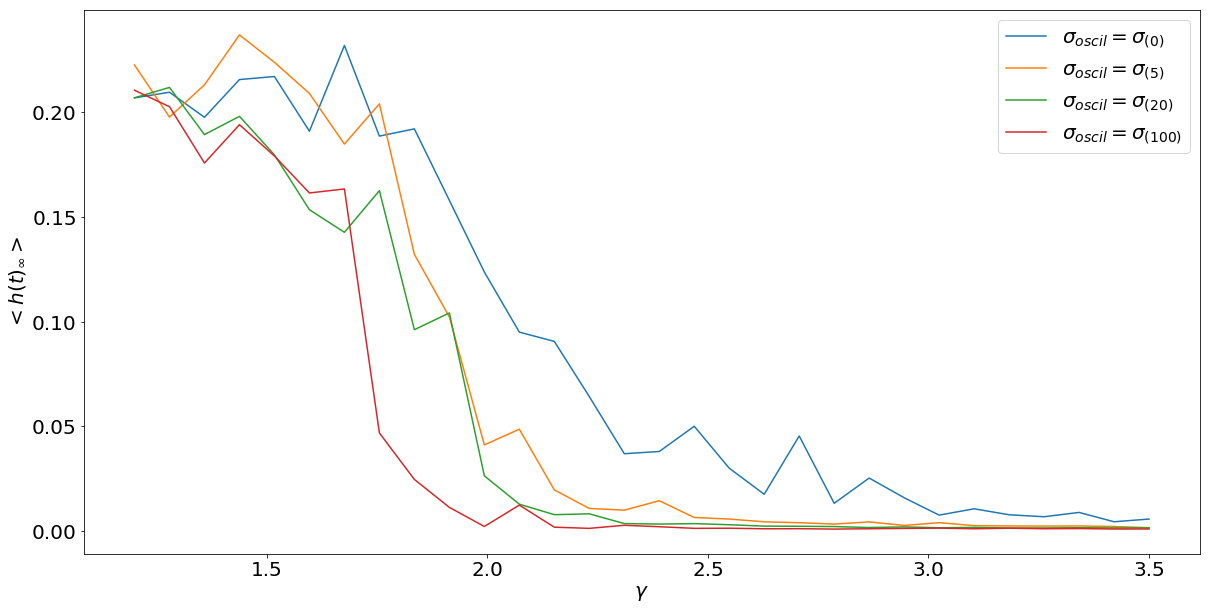

In [28]:
myRange = np.linspace(1.2,3.5,30)
plt.plot(myRange, hub0, label="$\sigma_{oscil}=\sigma_{(0)}$")
plt.plot(myRange, hub5, label="$\sigma_{oscil}=\sigma_{(5)}$")
plt.plot(myRange, hub20, label="$\sigma_{oscil}=\sigma_{(20)}$")
plt.plot(myRange, hub100, label="$\sigma_{oscil}=\sigma_{(100)}$")
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel("$<h(t)_\\infty>$")
plt.show()


